# **PROJET STATISTIQUE DES RISQUES EXTRÊMES**

---
title: Modélisation de la value at risk

authors:
  - name: Jumbong Junior

    email: junior.jumbong@eleve.ensai.fr

    role: Etudiant


  - name: Ganiyu Isaac

    email: isaac.ganiyu@eleve.ensai.fr
    
    role: Etudiant
---

# Init 

### Import des données 

In [107]:
!pip install yfinance
!pip install arch


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
np.random.seed(42)

In [109]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Télécharger les données historiques du CAC 40
cac_40 = yf.Ticker("^FCHI")
data = cac_40.history("max")

# Formater l'index en année-mois-jour
data.index = data.index.strftime('%Y-%m-%d')

ts_data = data
ts_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-03-01,1836.000000,1838.000000,1827.000000,1832.000000,0,0.0,0.0
1990-03-02,1831.000000,1860.000000,1831.000000,1860.000000,0,0.0,0.0
1990-03-05,1866.000000,1874.000000,1862.000000,1874.000000,0,0.0,0.0
1990-03-06,1869.000000,1875.000000,1866.000000,1872.000000,0,0.0,0.0
1990-03-07,1874.000000,1881.000000,1874.000000,1880.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-05,7591.770020,7606.120117,7558.229980,7589.959961,51727200,0.0,0.0
2024-02-06,7634.189941,7641.629883,7592.089844,7638.970215,56890100,0.0,0.0
2024-02-07,7632.839844,7652.850098,7610.180176,7611.259766,62951100,0.0,0.0


### Mise en forme et nettoyage des données 

In [110]:
ts_close = ts_data[[ 'Close']]

In [111]:
### Visualisation des valuers manquantes 
print(f"Y'a t-il des valeurs manquantes ? {any(pd.isna(ts_close['Close']))}")
ts_close[pd.isna(ts_close['Close'])]

Y'a t-il des valeurs manquantes ? False


,Close
Date,


Nous n'avons aucune valeur manquante dans nos données

### calcul du log rendement 

In [112]:
ts_close['log_return'] = np.log(ts_close['Close'] / ts_close['Close'].shift(1))
ts_close = ts_close.dropna(subset=['log_return'])
print(ts_close.head())

             Close  log_return
Date                          
1990-03-02  1860.0    0.015168
1990-03-05  1874.0    0.007499
1990-03-06  1872.0   -0.001068
1990-03-07  1880.0    0.004264
1990-03-08  1917.0    0.019490



### Représentation de la série des cours et de la série des log rendements en fonction de la date

<Figure size 1200x1200 with 0 Axes>

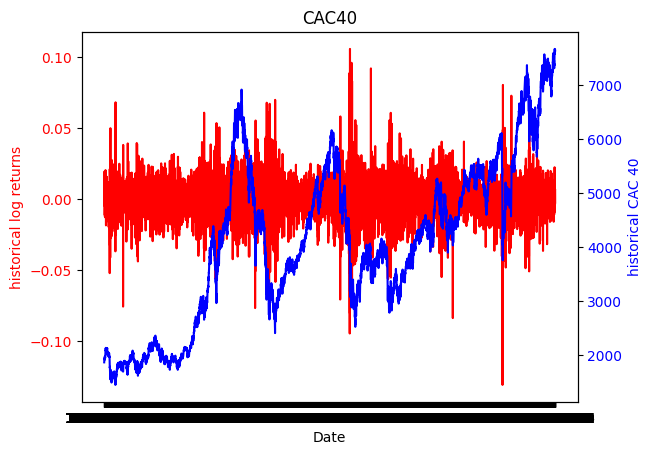

In [113]:

plt.figure(figsize=(12, 12))

fig, ax1 = plt.subplots(1)

ax1.set_xlabel('Date')
ax1.set_ylabel('historical log returns', color='red')
ax1.plot(ts_close.index, ts_close['log_return'], color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('historical CAC 40', color='blue')
ax2.plot(ts_close.index, ts_close['Close'], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')



plt.title('CAC40')
plt.show()

Le graphique ci-dessus représente la série des cours et la série des log rendements du CAC40 en fonction de la date.
La série des cours est assez volatile et a une tendance à la hausse non-linéaire. Il semble qu'elle ne soit pas stationnaire. Cependant, la série des log rendements a une tendance constante et semble être stationnaire. Nous vérifierons cela également à travers les fonctions d'autocorrélation et d'autocorrélation partielle et par le test de Dickey-Fuller.


### Fonction d'autocorrélation et d'autocorrélation partielle de la série des log rendements

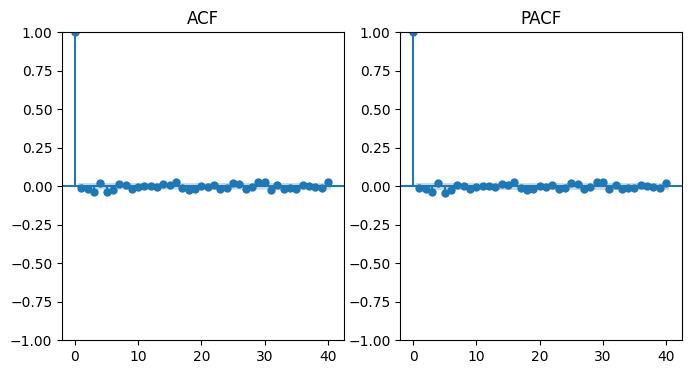

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_acf(ts_close['log_return'].dropna(), ax=ax[0],title='ACF')
plot_pacf(ts_close['log_return'].dropna(), ax=ax[1],title='PACF')
plt.show()

Comme nous pouvons le voir sur les graphiques ci-dessus, l'autocorrélation et l'autocorrélation partielle des log rendements sont très faibles. Cela signifie que les log rendements sont stationnaires. Nous vérifierons cela à travers le test de Dickey-Fuller.

### Etude de la stationnarité

In [115]:
## Test de dickey fuller

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(ts_close['log_return'].dropna(), regression='ct')
print(f"ADF Statistic: {adf_result[0]}" and f"p-value: {adf_result[1]}")

p-value: 0.0


La pvalue étant nulle, on rejette l'hypothèse nulle de présence d'une racine unitaire. La série des log rendements est donc stationnaire. Par conséquent, nous travaillerons avec cette série pour modéliser la VaR à horizon 1 jour.


### Découpage train test 

In [116]:
# Nous considérons 75% de nos données dans l'échantillon d'apprentissage et 25% dans l'échantillon de test
train_size = int(len(ts_close)*0.75)
test_size = len(ts_close)-train_size

train_close = ts_close.iloc[0:train_size,:].dropna()
test_close = ts_close.iloc[train_size:len(ts_close),:]
print("Taille de l'ensemble d'apprentissage :", len(train_close))
print("Taille de l'ensemble de test :", len(test_close))
pd.isna(train_close).sum()

Taille de l'ensemble d'apprentissage : 6463
Taille de l'ensemble de test : 2155


Close         0
log_return    0
dtype: int64

### Statistiques descriptives des rendements 

In [117]:
train_close['log_return'].describe()

count    6463.000000
mean        0.000141
std         0.014046
min        -0.094715
25%        -0.007011
50%         0.000366
75%         0.007716
max         0.105946
Name: log_return, dtype: float64

In [118]:
test_close['log_return'].describe()

count    2155.000000
mean        0.000241
std         0.011963
min        -0.130983
25%        -0.004868
50%         0.000643
75%         0.006041
max         0.080561
Name: log_return, dtype: float64

Sur les deux jeux de données les log rendements sont relativement volatiles avec une dispersion plus importante pour la base d'apprentissage que pour la base de test. On remarque par ailleurs que le min est plus petit et le max plus grand dans la base d'apprentissage que dans la base de test. Nous pouvions nous y attendre car la base d'apprentissage couvre une période plus longue. Les deux séries sont malgré tout assez semblables en terme de moyenne avec une moyenne d'environ 0.015%.

# Modélisation de la VaR.

La var est définie comme la perte potentielle maximale que peut subir un portefeuille sur un horizon avec un certain niveau de confiance. Dans ce notebook, nous adopterons une vision rentabilité. Dans ce cas, nous allons modéliser :
    $P[R<VaR_h] =1- \alpha$.

Nous allons appliquer les différentes méthodes de modélisation de la Var:

    - Méthodes non-paramétriques
        - VaR historique
        - VaR bootstrap
    - Méthodes paramétriques
        - VaR gaussienne
        - VaR skew student
        - VaR TVE (Théorie des valeurs extrêmes)
        - VaR AR-GARCH

# VaR non paramétrique

## VaR historique :

Ici on estime la distribution des rendements R par la fonction de répartition empirique du vecteur d'observations. La VaR est alors donnée par le quantile empirique d'ordre $1-\alpha$ :

$\hat{VaR}_h(\alpha) = \hat{F_n^{-1}}(1-\alpha)$ avec  $\hat{F_n}(1-\alpha)= \frac{1}{n} \sum_{i=1}^{n} 1_{R_i \leq (1-\alpha)}$

Nous utiliserons ainsi la fonction `numpy.percentile` pour calculer la VaR historique.

In [119]:
def hist_var(returns, index, fenetre, seuil):
    """Cette fonction calcule la Value at Risk (VaR) historique d'une série temporelle de log rendements

    Args:
        returns (numpy_array ): serie de log rendements
        index (int): indice maximal de la série à considérer pour le calcul
        fenetre (int): nombre de jours sur lesquels on calcule la VaR
        seuil (float): niveau de confiance de la VaR

    Return:
        float: VaR historique
    """
    return np.percentile(returns[index-fenetre:index], 100*(1-seuil))

In [120]:
var_hist= hist_var(train_close["log_return"], train_size, 251*10, 0.99) #on utilise 10 ans comme fenêtre
print(var_hist)

-0.04320825141346711


## Backtesting

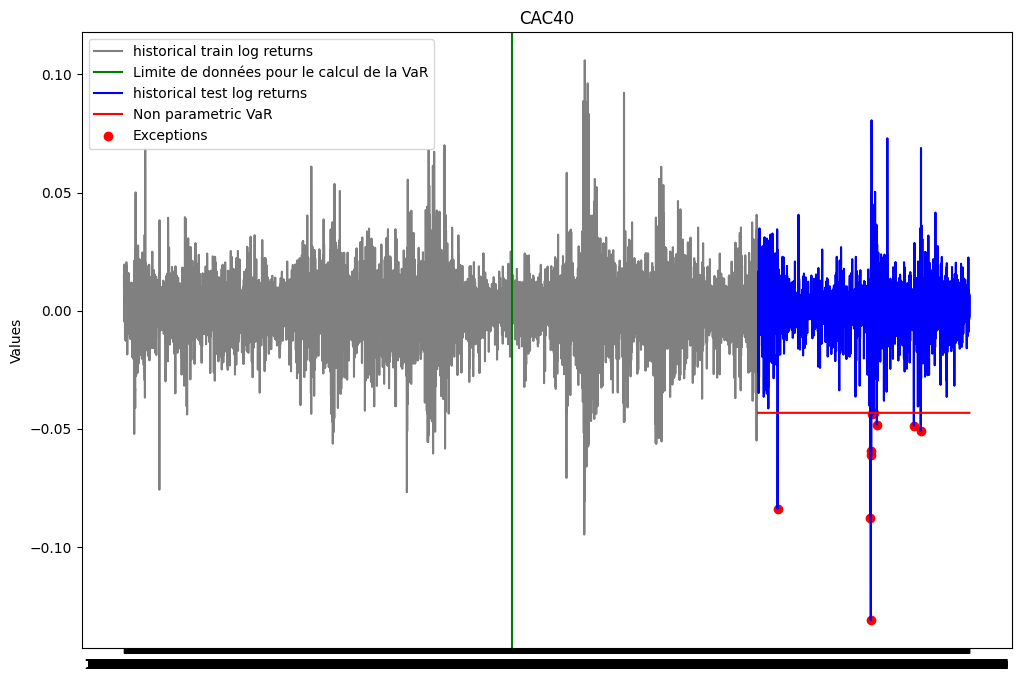

In [121]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index[0:train_size], train_close['log_return'], label="historical train log returns", color = 'gray')
plt.axvline(x = ts_close.index[train_size-251*10-1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
plt.plot(ts_close.index[train_size:], test_close['log_return'], label="historical test log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], [var_hist for i in range(test_size)], label="Non parametric VaR", color = 'red')
list_exceptions_np = [i for i in range(len(test_close['log_return'])) if test_close['log_return'][i]<var_hist]
plt.scatter(test_close.index[list_exceptions_np], test_close['log_return'][list_exceptions_np], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

In [122]:
print(f"Le nombre d'exceptions pour la VaR non paramétrique est: {len(list_exceptions_np)}")
print(f"Le pourcentage d'exceptions pour la VaR non paramétrique est: {len(list_exceptions_np)/test_size}")

Le nombre d'exceptions pour la VaR non paramétrique est: 10
Le pourcentage d'exceptions pour la VaR non paramétrique est: 0.004640371229698376


Nous allons maintenant vérifier si la probabilité d'exception est statiquement égale à $\alpha$.

In [123]:
from scipy import stats

test_except_np = stats.binomtest(len(list_exceptions_np), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_np.pvalue}')

la p-value du test binomial est: 0.008950138322753154


La pvalue du test est inférieure au seuil de 5%. On rejette donc l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%. Nous concluons donc que notre VaR n'est pas satisfaisante. 

In [124]:
ES_np = np.mean([r for r in train_close['log_return'] if r<var_hist])
print(f"L'Expected Shortfall associée à la VaR calculée est: {ES_np}")

L'Expected Shortfall associée à la VaR calculée est: -0.054387464763168906


## VaR historique Bootstrap

Pour la VaR historique boostrap, nous allons construire B réplications bootstrap de la série des log rendements. Pour chaque réplication(b), nous allons calculer la VaR historique. La VaR historique bootstrap est alors donnée par la moyenne des VaR historiques des B réplications bootstrap.

$\hat{VaR}_{h,bootstrap}(\alpha) = \frac{1}{B} \sum_{b=1}^{B} \hat{VaR}_{h,b}(\alpha)$

Nous avons aussi calculé l'intervalle de confiance à 95% de la VaR historique bootstrap. Cet intervalle est donné par les quantiles empiriques d'ordre 2.5% et 97.5% des VaR historiques des B réplications bootstrap.

In [125]:

def VaR_Hist_Bootstrap(returns, seuil, num_simulations, alpha_IC, n_B):


    VaRs_boot = np.zeros(num_simulations)

    for i in range(num_simulations):
        sample = np.random.choice(returns, n_B, replace=True)
        VaRs_boot[i] = hist_var(sample, len(sample), len(sample), seuil)

    VaR = np.mean(VaRs_boot)

    lower_bound = np.percentile(VaRs_boot, 100 * (1-alpha_IC) / 2)
    upper_bound = np.percentile(VaRs_boot, 100 * (1 - (1-alpha_IC) / 2))
    IC = (lower_bound, upper_bound)

    return VaR, IC

In [126]:
seuil = 0.99
seuil_IC = 0.9
num_simulations = 5000
n_B = 251*10 #on utilise 10 ans de données comme taille d'échantillon bootstrap
var_hist_boot, IC_hist_boot = VaR_Hist_Bootstrap(train_close["log_return"], seuil, num_simulations,
                                                 seuil_IC, n_B) 
print(f"La VaR historique bootstrap: {var_hist_boot}")
print(f"L'intervalle de confiance associé est: {IC_hist_boot}")

La VaR historique bootstrap: -0.039930947829674754
L'intervalle de confiance associé est: (-0.043415059657731805, -0.03610734170316266)


Notre estimation bootstrap de la VaR se trouve bien dans l'intervalle de confiance à 90%. Nous pouvons donc conclure que notre estimation de la VaR est satisfaisante.

## Backtesting

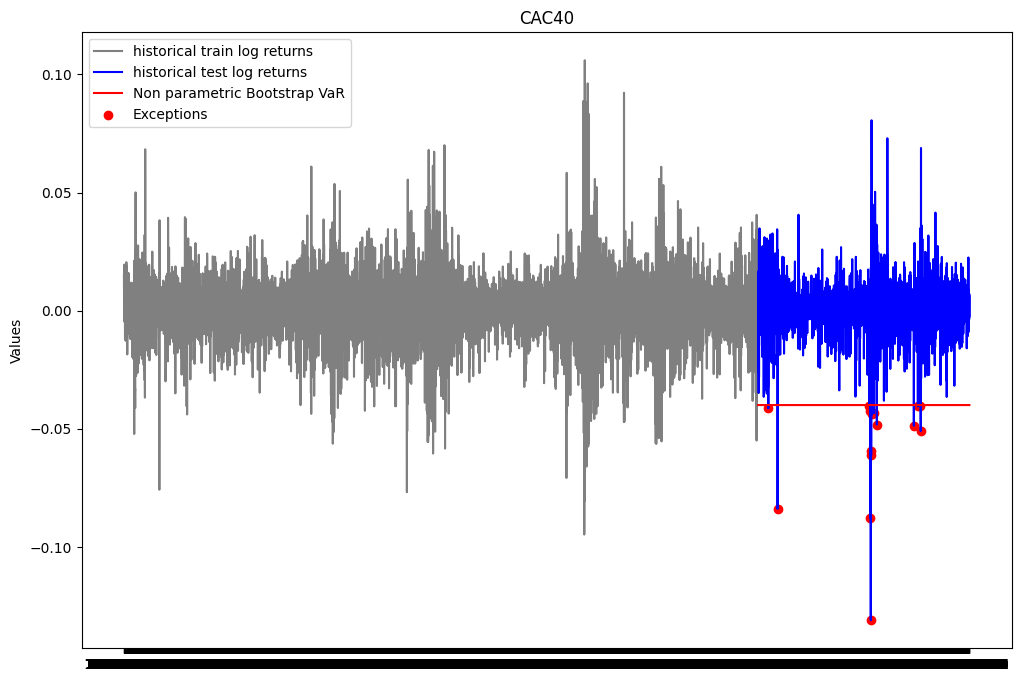

In [127]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index[0:train_size], train_close['log_return'], label="historical train log returns", color = 'gray')
plt.plot(ts_close.index[train_size:], test_close['log_return'], label="historical test log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], [var_hist_boot for i in range(test_size)], label="Non parametric Bootstrap VaR", color = 'red')
list_exceptions_np_boot = [i for i in range(len(test_close['log_return'])) if test_close['log_return'][i]<var_hist_boot]
plt.scatter(test_close.index[list_exceptions_np_boot], test_close['log_return'][list_exceptions_np_boot], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

In [128]:
print(f"Le nombre d'exceptions pour la VaR Bootstrap non paramétrique est: {len(list_exceptions_np_boot)}")
print(f"Le pourcentage d'exceptions pour la VaR Bootstrap non paramétrique est: {len(list_exceptions_np_boot)/test_size}")

Le nombre d'exceptions pour la VaR Bootstrap non paramétrique est: 16
Le pourcentage d'exceptions pour la VaR Bootstrap non paramétrique est: 0.007424593967517401


In [215]:
test_except_np_boot = stats.binomtest(len(list_exceptions_np_boot), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_np_boot.pvalue}')

la p-value du test binomial est: 0.2775641662941861


Le test binomial vient confirmer les conclusions faites à partir de l'intervalle de confiance estimé.

In [129]:
ES_np_boot = np.mean([r for r in train_close['log_return'] if r<var_hist_boot])
print(f"L'Expected Shortfall associée à la VaR calculée est: {ES_np_boot}")

L'Expected Shortfall associée à la VaR calculée est: -0.05028777316523479


# Méthodes paramétriques d'estimation de la VaR

## VaR gaussienne 

La VaR gaussienne suppose que les rendements suivent une loi normale. Dans ce cas, on a $P(R<VaR_h(\alpha)) = 1-\alpha$ qui est équivalent à $P(\frac{R-\mu}{\sigma} < \frac{VaR_h(\alpha)-\mu}{\sigma}) = 1-\alpha$ en supposant que R suit une loi normale de moyenne $\mu$ et d'écart type $\sigma$. On a alors $VaR_h(\alpha) = \mu + \sigma \Phi^{-1}(1-\alpha)$. On peut estimer les paramètres à partir de l'échantillon. On a alors $\hat{VaR}_h(\alpha) = \hat{\mu} + \hat{\sigma} \Phi^{-1}(1-\alpha)$.

In [130]:
from scipy import stats
def var_gaussienne(returns, index, fenetre, seuil):
    rendements = returns[index-fenetre:index]
    mean_returns = np.mean(rendements)
    sd_returns = np.std(rendements)
    VaR = mean_returns + sd_returns * stats.norm.ppf(1-seuil)
    return VaR

In [131]:
## VaR gaussienne sur base d'apprentissage

var_gaus = var_gaussienne(train_close["log_return"], train_size, 251*10, 0.99) #on utilise 10 ans comme fenêtre
print(var_gaus)

-0.034733067424936016


### Validation

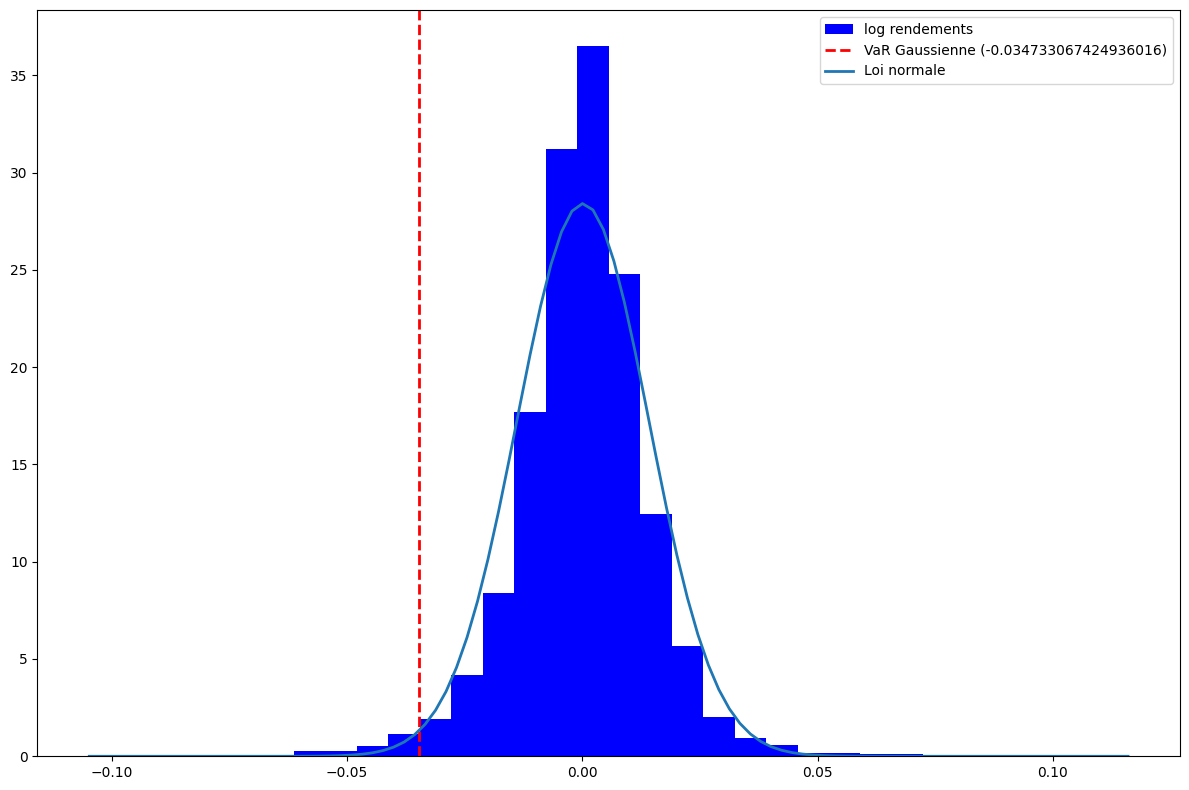

In [132]:
# analyse graphique avec les densités des distributions
plt.figure(figsize = (12,8))
plt.hist(train_close["log_return"], bins=30, density=True, color='blue', label = 'log rendements')
plt.axvline(var_gaus, color='red', linestyle='dashed', linewidth=2, label=f'VaR Gaussienne ({var_gaus})')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(train_close["log_return"]), np.std(train_close["log_return"]))
plt.plot(x, p, label = 'Loi normale', linewidth=2)

plt.legend()
plt.tight_layout()
plt.show()

On remarque que la queue de la loi normale n'est pas assez lourde pour nos données. La loi normale aura donc tendance à mal estimer les queues de distribution.

Text(0.5, 1.0, 'QQ-plot')

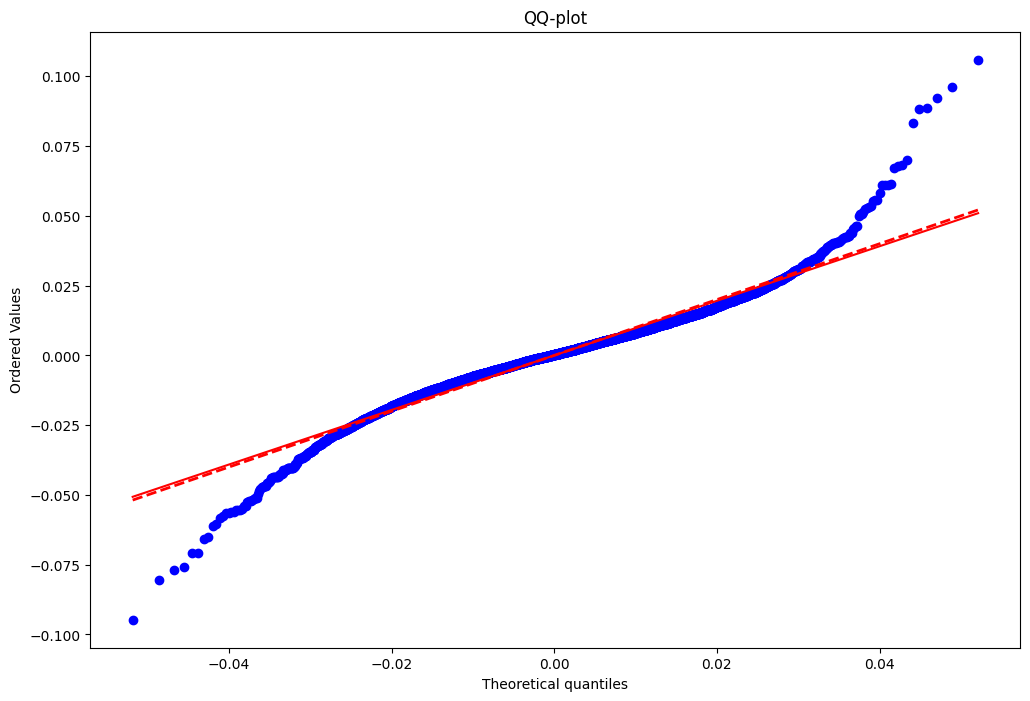

In [133]:
## Analyse graphique avec le QQ-plot

plt.figure(figsize=(12, 8))
probplot = stats.probplot(train_close["log_return"], 
                        sparams = (np.mean(train_close["log_return"]), np.std(train_close["log_return"])), 
                        dist='norm', plot=plt)
plt.plot(probplot[0][0], probplot[0][0], color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title('QQ-plot')

Nous constatons que lorsqu'on utilise la loi normale pour la modélisation de la VaR, au niveau des queues de distribution,les quantiles théoriques sont moins élévés que les quantiles empiriques à gauche et plus élevés à droite. Cela signifie que la loi normale sous-estime la probabilité d'exception. La loi normale semble donc ne pas être adaptée pour modéliser la VaR.

In [134]:
## Test d'adéquation

# Test de Kolmogorov-Smirnov
ks_statistic, ks_p_value = stats.kstest(train_close["log_return"], 'norm', args = (np.mean(train_close["log_return"]), np.std(train_close["log_return"])))
print(f"Test de Kolmogorov-Smirnov - Statistique : {ks_statistic},\nP-value : {ks_p_value}")

Test de Kolmogorov-Smirnov - Statistique : 0.05681055751622879,
P-value : 1.4266789934088429e-18


On rejette l'hypothèse nulle selon laquelle les log rendements suivent une distribution normale.

### Représentation graphique

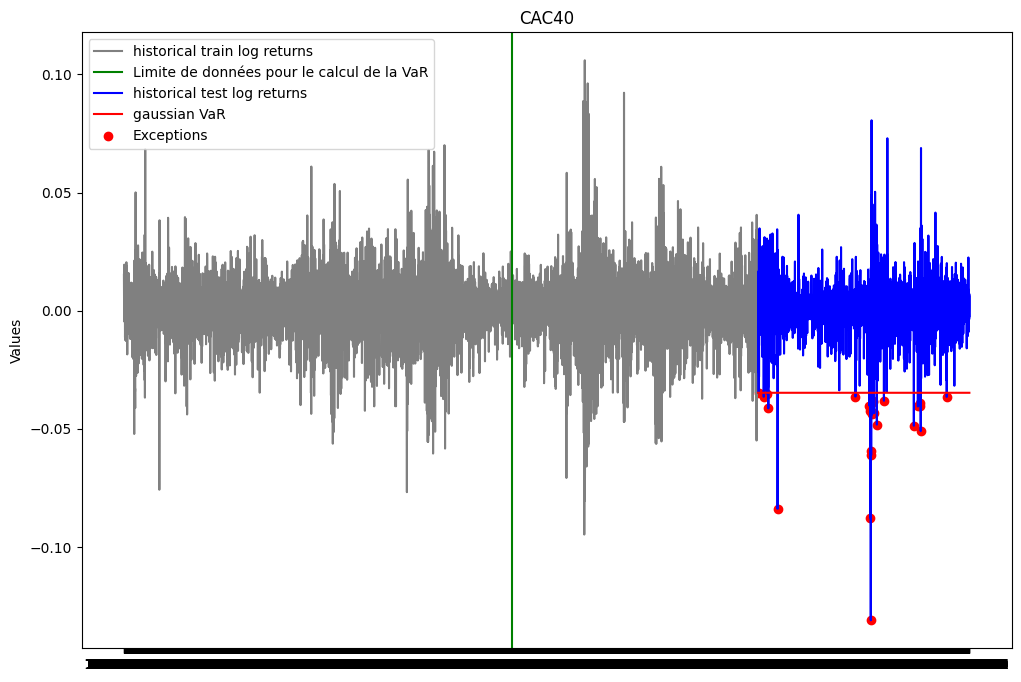

In [135]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index[0:train_size], train_close['log_return'], label="historical train log returns", color = 'gray')
plt.axvline(x = ts_close.index[train_size-251*10-1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
plt.plot(ts_close.index[train_size:], test_close['log_return'], label="historical test log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], [var_gaus for i in range(test_size)], label="gaussian VaR", color = 'red')
list_exceptions_gaus = [i for i in range(len(test_close['log_return'])) if test_close['log_return'][i]<var_gaus]
plt.scatter(test_close.index[list_exceptions_gaus], test_close['log_return'][list_exceptions_gaus], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

### Analyse des exceptions

In [136]:
print(f"Le nombre d'exceptions pour la VaR gaussienne est: {len(list_exceptions_gaus)}")
print(f"Le pourcentage d'exceptions pour la VaR gaussienne est: {len(list_exceptions_gaus)/test_size}")

Le nombre d'exceptions pour la VaR gaussienne est: 25
Le pourcentage d'exceptions pour la VaR gaussienne est: 0.01160092807424594


In [137]:
test_except_gaus = stats.binomtest(len(list_exceptions_gaus), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_gaus.pvalue}')

la p-value du test binomial est: 0.44697408691382107


La pvalue du test est supérieure au seuil de 5%. On ne peut donc pas rejeter l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%.

### VaR gaussienne à 10 jours

In [138]:
## Var gaussienne à 10 jours par la méthode de scaling

periode = 10
var_gaus_scaling = np.sqrt(periode)*var_gaus
print(f"La VaR gaussienne à 10 jours par la méthode de scaling est: {var_gaus_scaling}")

La VaR gaussienne à 10 jours par la méthode de scaling est: -0.10983560318699723


In [139]:
## VaR gaussienne à 10 jours par la méthode de diffusion
from numpy import random

periode = 10
n_simul = 10000
S0 = train_close['Close'].iloc[-1]
mean_returns = np.mean(train_close["log_return"])
sd_returns = np.std(train_close["log_return"])
simulations = []
for k in range(n_simul):
    simul_k=[S0]
    for _ in range(periode):
        Z = random.standard_normal()
        dS = simul_k[-1]*mean_returns + simul_k[-1]*sd_returns*Z
        simul_k.append(simul_k[-1]+dS)
    simulations.append(simul_k)

rend10 = [np.log(simul[10] / S0) for simul in simulations]

alpha = 0.99
var_gaus_diff = np.percentile(rend10, 100*(1-alpha))
print(f"La VaR gaussienne à 10 jours par la méthode de diffusion est: {var_gaus_diff}")

La VaR gaussienne à 10 jours par la méthode de diffusion est: -0.10286418206833377


### VaR gaussienne pondérée :

Une façon de corriger la VaR, est de pondérer la moyenne et l'écart type des rendements. On peut utiliser une moyenne mobile pondérée.

In [140]:
from scipy import stats
def var_gaussienne_ewma(returns, index, fenetre, seuil, lambd):
    rendements = returns[index-fenetre:index]
    n = len(rendements)
    poids = [(lambd**i)*(1-lambd) for i in range(n)]
    denom = sum(poids)
    poids_pond = [poid/denom for poid in poids]
    moy_pond = np.sum([poids_pond[i]*rendements[n-i-1] for i in range(n)])
    variance_pond = np.sum([poids_pond[i]*(rendements[n-i-1]-moy_pond)**2 for i in range(n)])
    VaR = moy_pond + np.sqrt(variance_pond) * stats.norm.ppf(1-seuil)
    return moy_pond, variance_pond, VaR

____________________________________________________________________________________________________
lambda = 0.9
Moyenne pondérée: -0.002655293241077962
Variance pondérée: 0.0003655826690051906
VaR gaussienne EWMA: -0.047135567638603576
Nombre d'exceptions: 8
Pourcentage d'exceptions: 0.0037122969837587007
____________________________________________________________________________________________________
lambda = 0.95
Moyenne pondérée: -0.0024114946992036604
Variance pondérée: 0.0003654872172300481
VaR gaussienne EWMA: -0.04688596193096311
Nombre d'exceptions: 8
Pourcentage d'exceptions: 0.0037122969837587007
____________________________________________________________________________________________________
lambda = 0.99
Moyenne pondérée: -0.0005003090834522245
Variance pondérée: 0.00022779933004877785
VaR gaussienne EWMA: -0.03561193003277455
Nombre d'exceptions: 23
Pourcentage d'exceptions: 0.010672853828306265


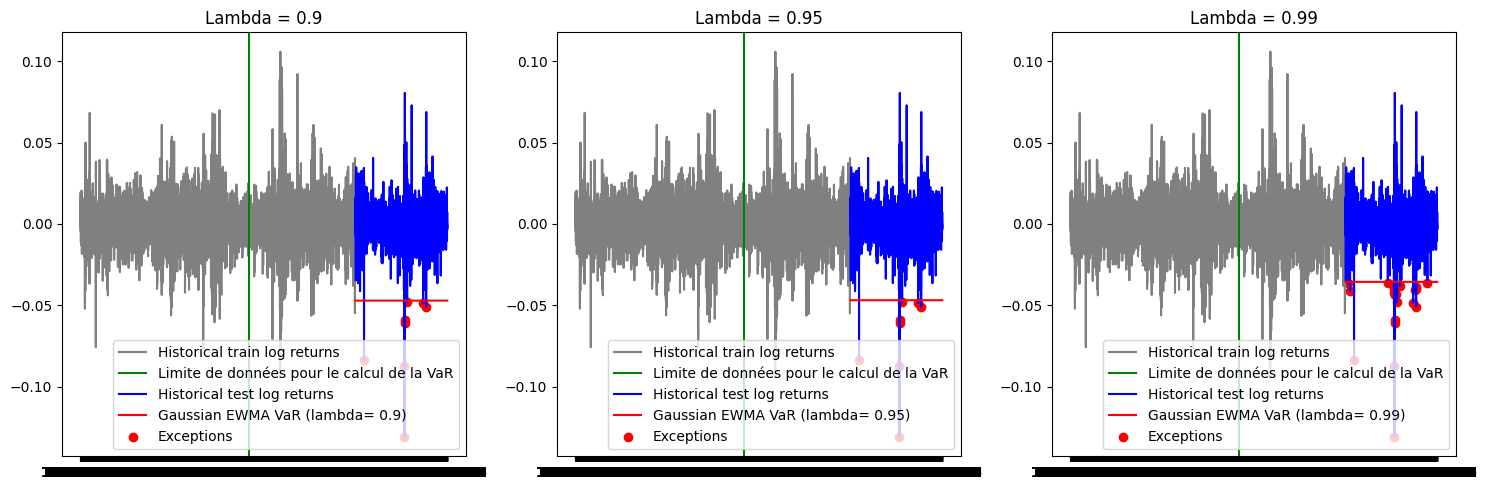

In [141]:
## Calcul 

lambd1= 0.9
lambd2 = 0.95
lambd3 = 0.99
moy_pond1, variance_pond1, VaR1 = var_gaussienne_ewma(train_close["log_return"], train_size, 251*10, 0.99, lambd1)
moy_pond2, variance_pond2, VaR2 = var_gaussienne_ewma(train_close["log_return"], train_size, 251*10, 0.99, lambd2)
moy_pond3, variance_pond3, VaR3 = var_gaussienne_ewma(train_close["log_return"], train_size, 251*10, 0.99, lambd3)

list_exceptions_gaus1 = [i for i in range(len(test_close['log_return'])) if test_close['log_return'][i]<VaR1]
print(100*"_"+ f"\nlambda = {lambd1}\nMoyenne pondérée: {moy_pond1}\nVariance pondérée: {variance_pond1}\nVaR gaussienne EWMA: {VaR1}\nNombre d'exceptions: {len(list_exceptions_gaus1)}\nPourcentage d'exceptions: {len(list_exceptions_gaus1)/test_size}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Premier graphique
axes[0].plot(ts_close.index[0:train_size], train_close['log_return'], label="Historical train log returns", color='gray')
axes[0].axvline(x=ts_close.index[train_size - 251*10 - 1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
axes[0].plot(ts_close.index[train_size:], test_close['log_return'], label="Historical test log returns", color='blue')
axes[0].plot(ts_close.index[train_size:], [VaR1 for _ in range(test_size)], label=f"Gaussian EWMA VaR (lambda= {lambd1})", color='red')
axes[0].scatter(test_close.index[list_exceptions_gaus1], [test_close['log_return'][i] for i in list_exceptions_gaus1], color='red', label='Exceptions')
axes[0].set_title('Lambda = 0.9')
axes[0].legend()

list_exceptions_gaus2 = [i for i in range(len(test_close['log_return'])) if test_close['log_return'][i]<VaR2]
print(100*"_"+ f"\nlambda = {lambd2}\nMoyenne pondérée: {moy_pond2}\nVariance pondérée: {variance_pond2}\nVaR gaussienne EWMA: {VaR2}\nNombre d'exceptions: {len(list_exceptions_gaus2)}\nPourcentage d'exceptions: {len(list_exceptions_gaus2)/test_size}")

# Deuxième graphique
axes[1].plot(ts_close.index[0:train_size], train_close['log_return'], label="Historical train log returns", color='gray')
axes[1].axvline(x=ts_close.index[train_size - 251*10 - 1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
axes[1].plot(ts_close.index[train_size:], test_close['log_return'], label="Historical test log returns", color='blue')
axes[1].plot(ts_close.index[train_size:], [VaR2 for _ in range(test_size)], label=f"Gaussian EWMA VaR (lambda= {lambd2})", color='red')
axes[1].scatter(test_close.index[list_exceptions_gaus2], [test_close['log_return'][i] for i in list_exceptions_gaus2], color='red', label='Exceptions')
axes[1].set_title('Lambda = 0.95')
axes[1].legend()


list_exceptions_gaus3 = [i for i in range(len(test_close['log_return'])) if test_close['log_return'][i]<VaR3]
print(100*"_"+ f"\nlambda = {lambd3}\nMoyenne pondérée: {moy_pond3}\nVariance pondérée: {variance_pond3}\nVaR gaussienne EWMA: {VaR3}\nNombre d'exceptions: {len(list_exceptions_gaus3)}\nPourcentage d'exceptions: {len(list_exceptions_gaus3)/test_size}")

# Troisième graphique
axes[2].plot(ts_close.index[0:train_size], train_close['log_return'], label="Historical train log returns", color='gray')
axes[2].axvline(x=ts_close.index[train_size - 251*10 - 1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
axes[2].plot(ts_close.index[train_size:], test_close['log_return'], label="Historical test log returns", color='blue')
axes[2].plot(ts_close.index[train_size:], [VaR3 for _ in range(test_size)], label=f"Gaussian EWMA VaR (lambda= {lambd3})", color='red')
axes[2].scatter(test_close.index[list_exceptions_gaus3], [test_close['log_return'][i] for i in list_exceptions_gaus3], color='red', label='Exceptions')
axes[2].set_title('Lambda = 0.99')
axes[2].legend()

plt.tight_layout()
plt.show()


In [216]:
test_except_gaus1 = stats.binomtest(len(list_exceptions_gaus1), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_gaus1.pvalue}')

la p-value du test binomial est: 0.0015372581472268324


In [217]:
test_except_gaus2 = stats.binomtest(len(list_exceptions_gaus2), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_gaus2.pvalue}')

la p-value du test binomial est: 0.0015372581472268324


In [219]:
test_except_gaus3 = stats.binomtest(len(list_exceptions_gaus3), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_gaus3.pvalue}')

la p-value du test binomial est: 0.7444680028961591


Seule la VaR estimée avec $\lambda$ = 0.99 a une p value supérieure au seuil de 5%. 

# VaR dynamique  :

Une autre façon de corriger la VaR est de la modéliser par un modèle dynamique. Ici on a pas besoin de diviser notre échantillon en base d'apprentissage et de test. Il suffit de choisir une fenêtre de temps pour estimer notre VaR. Ici nous allons choisir (251 jours) soit un an en considérant les jours ouvrés. Puis nous allons la faire glisser de 1 jour en 1 jour et la backtester le lendemain

La fonction hist_var écrite pour la VaR non paramétrique a été conçue pour pouvoir également calculer la VaR dynamique. Il suffit pour cela de faire varier l'index en paramètre.

In [142]:
vars_dyn = list(map(lambda index: hist_var(list(ts_close['log_return']), index, 251, 0.99), range(251, len(ts_close['log_return'])))) #on suppose qu'une année correspond à 251 jours ouvrés

### Réprésentation graphique

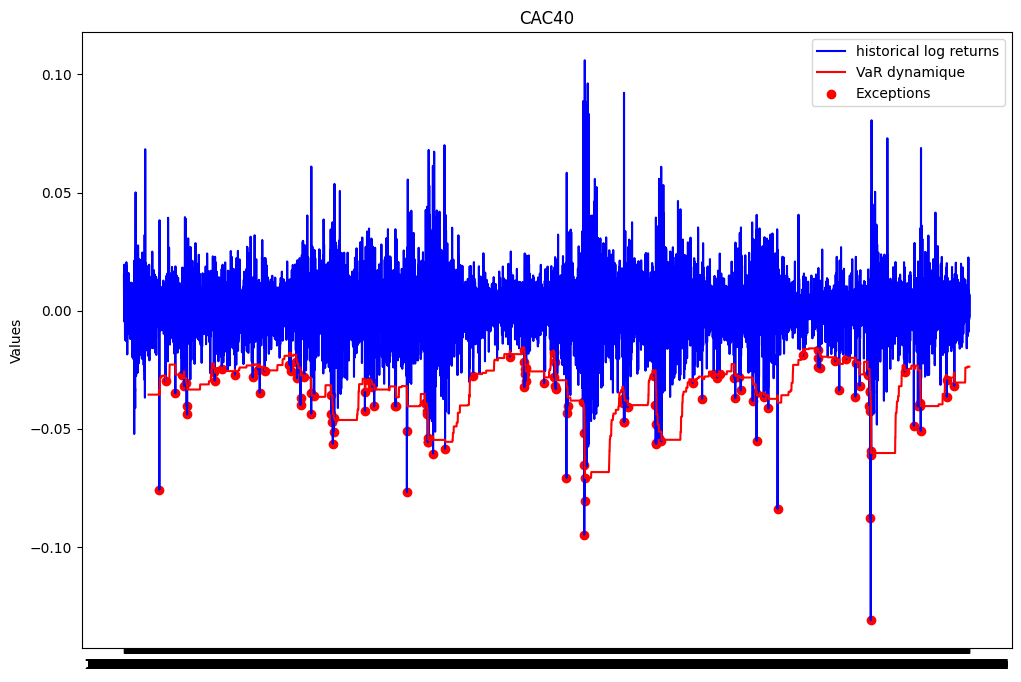

In [143]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index, ts_close['log_return'], label="historical log returns", color = 'blue')
plt.plot(ts_close.index[251:], vars_dyn, label='VaR dynamique', color = 'red')
list_exceptions_dyn = [i for i in range(251, len(ts_close['log_return'])) if ts_close['log_return'][i]<vars_dyn[i-251]]
plt.scatter(ts_close.index[list_exceptions_dyn], ts_close['log_return'][list_exceptions_dyn], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

In [144]:
print(f"Le nombre d'exceptions pour la VaR dynamique est: {len(list_exceptions_dyn)}")
print(f"Le pourcentage d'exceptions pour la VaR dynamique est: {len(list_exceptions_dyn)/len(vars_dyn)}")

Le nombre d'exceptions pour la VaR dynamique est: 133
Le pourcentage d'exceptions pour la VaR dynamique est: 0.015895781044579897


In [145]:
from scipy import stats

test_except_dyn = stats.binomtest(len(list_exceptions_dyn), len(vars_dyn), p = 0.01)
print(f'la p-value du test binomial est: {test_except_dyn.pvalue}')

la p-value du test binomial est: 5.082684955881415e-07


La p-value du test binomial est en dessous du seuil de 5%. On rejette donc l'hypothèse selon laquelle la probabilité d'exception est de 1%. Le modèle VaR estimé n'est pas satisfaisant.

# VaR skew-Student : 
La loi student a pour avantage de prendre en compte les queues de distribution des rendements. 
Dans cette partie, nous allons supposer que les rendements suivent une loi skew-student généralisée. Nous allons estimer les paramètres de la loi skew-student à partir de la série des log rendements par maximum de vraisemblance. Enfin, nous allons calculer la VaR à partir des paramètres estimés.

### fonction de densité de la skew-student

In [146]:
from scipy import special 

def SkStudentPdf(x:float, mu, sigma, gamma, nu):
    point = gamma*(x-mu)*np.sqrt((nu+1)/(((x-mu)/sigma)**2+nu))/sigma
    return 2*stats.t.pdf(x, df = nu, loc = mu, scale=sigma)*stats.t.cdf(point, nu+1)


In [147]:
mu = -0.1
sigma= 0.1
gamma = 1
nu = 4
SkStudentPdf(0.5, mu, sigma, gamma, nu)

0.022681128494391908

### Fonction de log vraisemblance

In [148]:
def minus_log_vrais(params, returns):
    mu, sigma, gamma, nu = params
    densities_values = SkStudentPdf(returns, mu, sigma, gamma, nu)
    log_densities_values = [np.log(value) for value in densities_values]
    return -np.sum(log_densities_values)

### fonction d'optimisation

In [149]:
# Fonction d'optimisation 

from scipy.optimize import minimize

def optim_func(data):
    # Estimer les paramètres par maximum de vraisemblance
    initial_guess = [np.mean(data), np.std(data), 1, 4]
    result = minimize(minus_log_vrais, initial_guess, args=(data,), method='Nelder-Mead')

    # Obtenez les paramètres estimés
    est_params = result.x

    return est_params


### Estimation des paramètres sur base d'apprentissage

In [150]:
est_params = optim_func(train_close['log_return'])
mu_est, sigma_est, gamma_est, nu_est = est_params
print(f"La valeur estimée des paramètres est:\nmu: {mu_est}\nsigma: {sigma_est}\ngamma: {gamma_est}\nnu: {nu_est}")

La valeur estimée des paramètres est:
mu: 0.002414916596402626
sigma: 0.010242362582207797
gamma: -0.23163817125525726
nu: 3.994213161152852


Le code ci-dessus a consisté à construire la densité de la skew-student, la fonction de la log vraisemblance et la fonction d'optimisation. Nous avons ensuite estimé les paramètres de la skew-student sur la base d'apprentissage. Nous pouvons évaluer la qualité de notre estimation par des analyses graphiques avant de passer à la modélisation de la VaR.

## Comparaison entre densité théorique et densité empirique de la skew-student sur les log rendements

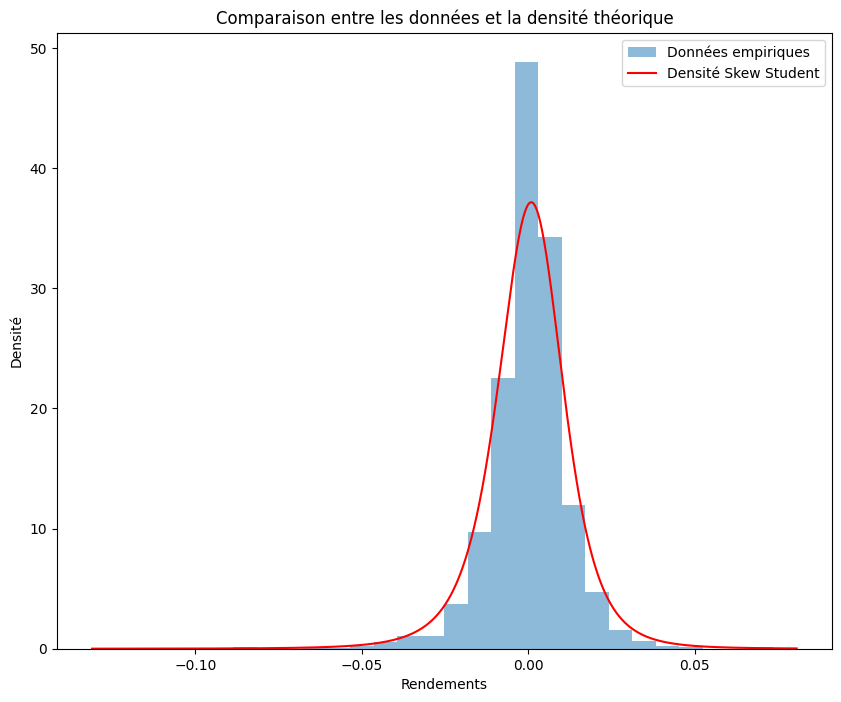

In [151]:

x_values = np.linspace(min(test_close['log_return']), max(test_close['log_return']), 1000)

mu, sigma, skew, df =est_params

theoretical_density = SkStudentPdf(x_values, mu, sigma, skew, df)
plt.figure(figsize = (10,8))
plt.hist(test_close['log_return'], bins=30, density=True, alpha=0.5, label='Données empiriques')

plt.plot(x_values, theoretical_density, label='Densité Skew Student', color='red')

# Personnalisation du graphique
plt.xlabel('Rendements')
plt.ylabel('Densité')
plt.title('Comparaison entre les données et la densité théorique')
plt.legend()

# Affichage du graphique
plt.show()

Le graphique ci-dessus est satisfaisant. La densité théorique de la skew-student est très proche de la densité empirique des log rendements. Nous pouvons donc conclure que la skew-student est une bonne modélisation des log rendements.

### Fonction de repartition de la skew-student et fonction quantile

In [152]:
## Intégration de la fonction de densité
from scipy import integrate
from scipy.optimize import minimize_scalar


def integrale_SkewStudent(x):
    borne_inf = -np.inf
    resultat_integration, erreur = integrate.quad(lambda x: SkStudentPdf(x, mu_est, sigma_est, gamma_est, nu_est), borne_inf, x)
    return resultat_integration

def fonc_minimize(x, alpha):
    value = integrale_SkewStudent(x)-alpha
    return abs(value)

def theoretical_quantile(alpha):
    if alpha <0 or alpha >1:
        raise Exception("Veuillez entrer un niveau alpha entre 0 et 1")
    else:
        resultat_minimisation = minimize_scalar(lambda x: fonc_minimize(x, alpha))
        return resultat_minimisation.x



Le code ci-dessus nous a permis de construire la fonction de repartition de la skew-student ainsi que la fonction quantile qui est l'inverse de cette fonction de repartition. Cette fonction quantile est le coeur de la modélisation de la VaR.

### QQ plot :

Le graphique de QQ plot nous permettra de discuter de la qualité d'ajustement de la loi skew-student à la série des log rendements.

In [153]:
niveaux_quantiles = np.arange(0.001, 1, 0.001)

quantiles_empiriques = np.quantile(train_close['log_return'], niveaux_quantiles)
quantiles_theoriques = [theoretical_quantile(alpha) for alpha in niveaux_quantiles]

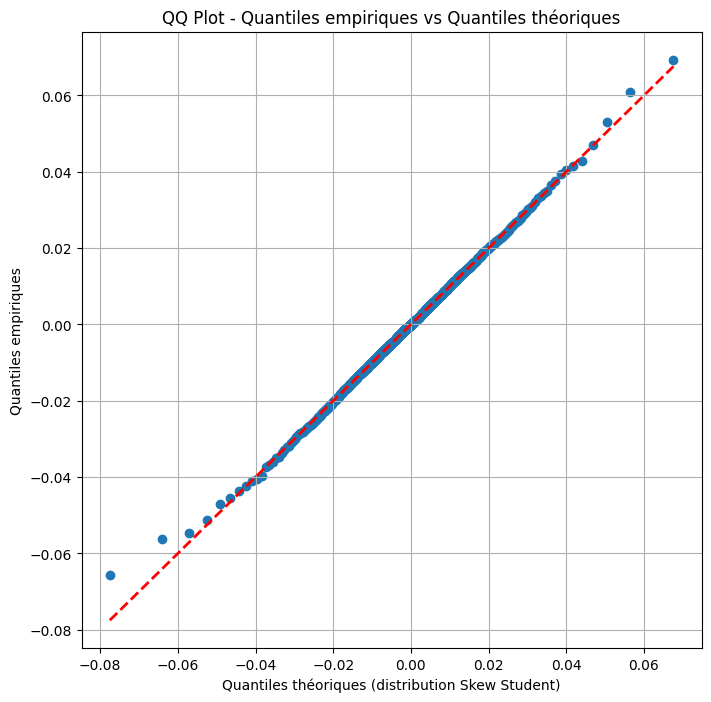

In [154]:

# Créer le QQ plot
plt.figure(figsize=(8, 8))
plt.scatter(quantiles_theoriques, quantiles_empiriques)
plt.plot(quantiles_theoriques, quantiles_theoriques, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title('QQ Plot - Quantiles empiriques vs Quantiles théoriques')
plt.xlabel('Quantiles théoriques (distribution Skew Student)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)
plt.show()

Nous constatons que la loi skew-student est une bonne approximation de la distribution des log rendements. Même si on constate des écarts aux queues de distribution, la loi skew-student semble bien modéliser la distribution des log rendements.

### comparaison entre loi gaussienne et loi de Skew Student

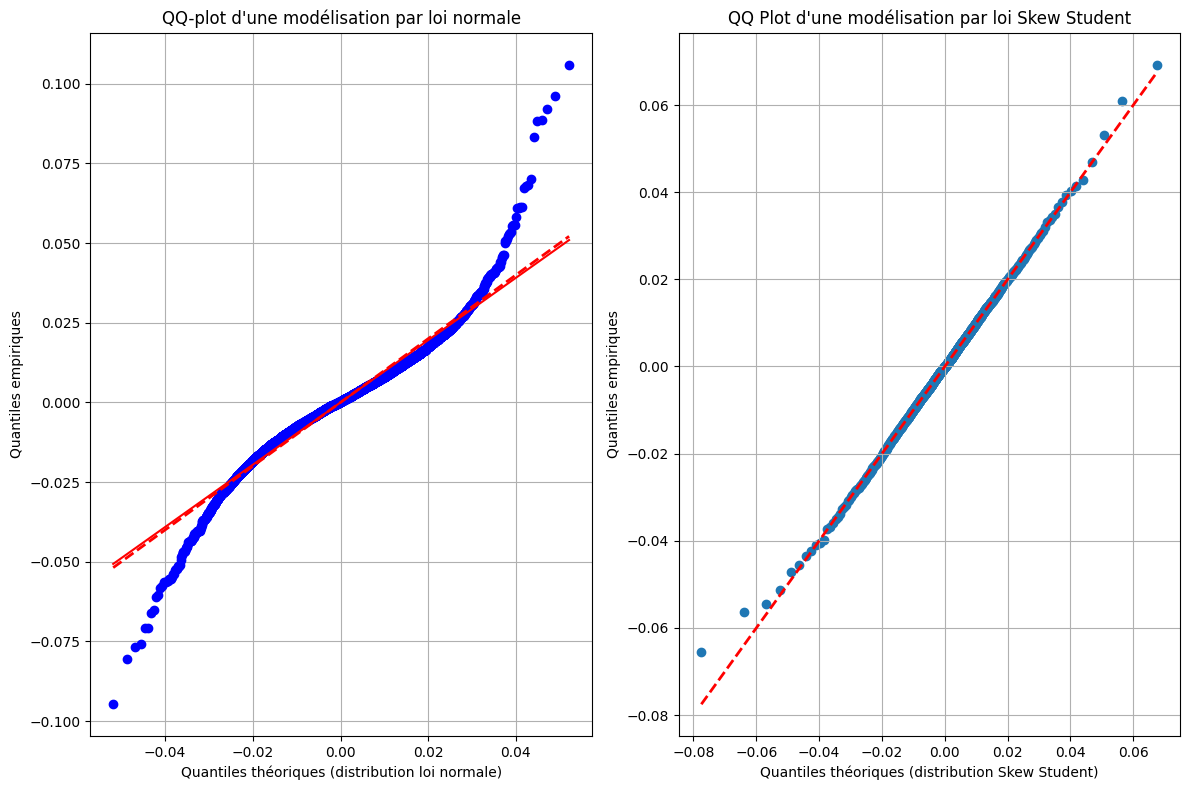

In [155]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
probplot = stats.probplot(train_close["log_return"], 
                        sparams = (np.mean(train_close["log_return"]), np.std(train_close["log_return"])), 
                        dist='norm', plot=plt)
plt.plot(probplot[0][0], probplot[0][0], color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.xlabel('Quantiles théoriques (distribution loi normale)')
plt.ylabel('Quantiles empiriques')
plt.title("QQ-plot d'une modélisation par loi normale")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(quantiles_theoriques, quantiles_empiriques)
plt.plot(quantiles_theoriques, quantiles_theoriques, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi Skew Student")
plt.xlabel('Quantiles théoriques (distribution Skew Student)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)

plt.tight_layout()
plt.show()


Comme on peut le voir sur le graphique ci-dessus, la loi skew-student est une meilleure approximation de la distribution des log rendements que la loi normale. En effet, les écarts aux queues de distribution sont moins importants pour la loi skew-student que pour la loi normale.

### Calcul de la VaR Skew Student

In [156]:
def var_skewstudent(returns, index, fenetre, seuil):
    rendements = returns[index-fenetre:index]
    mean_returns = np.mean(rendements)
    sd_returns = np.std(rendements)
    VaR =  theoretical_quantile(1-seuil)
    return VaR


In [157]:
## VaR Skew Student sur base d'apprentissage

var_skew = var_skewstudent(train_close["log_return"], train_size, train_size, 0.99) #on utilise 10 ans comme fenêtre
print(var_skew)

-0.039652480749928415


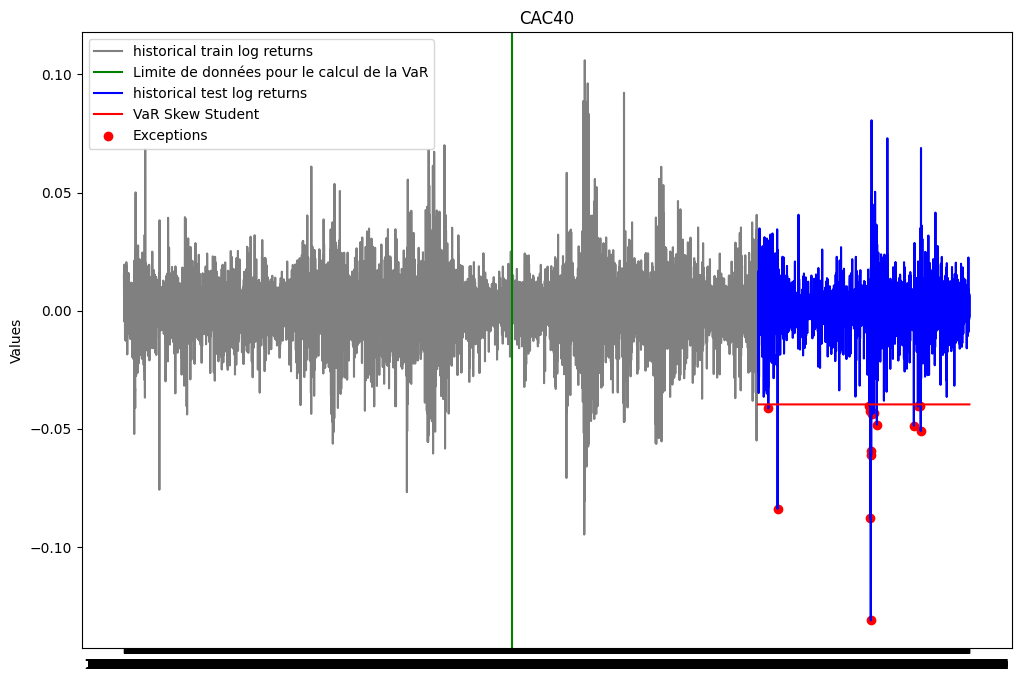

In [158]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index[0:train_size], train_close['log_return'], label="historical train log returns", color = 'gray')
plt.axvline(x = ts_close.index[train_size-251*10-1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
plt.plot(ts_close.index[train_size:], test_close['log_return'], label="historical test log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], [var_skew for i in range(test_size)], label="VaR Skew Student", color = 'red')
list_exceptions_skew = [i for i in range(len(test_close['log_return'])) if test_close['log_return'][i]<var_skew]
plt.scatter(test_close.index[list_exceptions_skew], test_close['log_return'][list_exceptions_skew], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

In [159]:
print(f"Le nombre d'exceptions pour la VaR Skew student est: {len(list_exceptions_skew)}")
print(f"Le pourcentage d'exceptions pour la VaR Skew Student est: {len(list_exceptions_skew)/test_size}")

Le nombre d'exceptions pour la VaR Skew student est: 16
Le pourcentage d'exceptions pour la VaR Skew Student est: 0.007424593967517401


In [160]:
test_except_skew = stats.binomtest(len(list_exceptions_skew), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_skew.pvalue}')

la p-value du test binomial est: 0.2775641662941861


La p-value du test binomial est au dessus du seuil de 5%. On ne peut donc pas rejeter l'hypothèse selon laquelle la probabilité d'exception est de 1%. Le modèle VaR Skew Student estimé semble donc satisfaisant.

# VaR TVE: Approche maxima par bloc

### Construction de l'échantillon de maxima

La TVE s'intéresse aux queues de distribution droite (maximum, excès par valeurs supérieures). On commence donc par convertir nos données en prenant l'opposé des données 

In [161]:
minus_train_returns = [-rtrn for rtrn in train_close["log_return"]]

In [162]:
def construct_max_data(returns, block_size):
    n = len(returns)
    num_blocks = n // block_size

    maxima_sample = []

    for i in range(num_blocks):
        block_start = i * block_size
        block_end = (i + 1) * block_size

        block_data = returns[block_start:block_end]

        max_in_block = np.max(block_data)

        maxima_sample.append(max_in_block)

    return maxima_sample

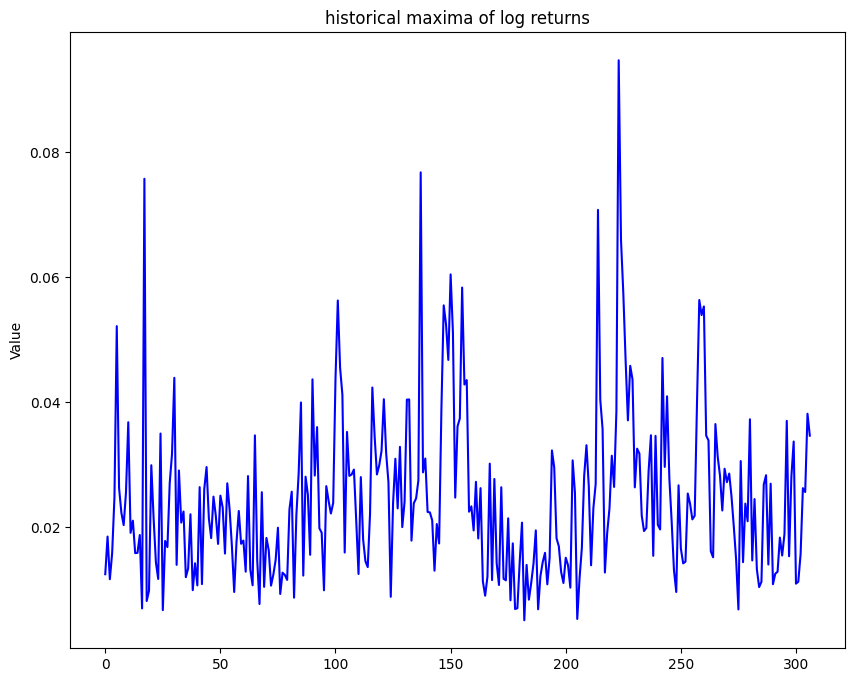

In [163]:
s= 21 # nombre de jours ouvrés dans le mois
maxima_train_sample = construct_max_data(minus_train_returns, s)

plt.figure(figsize=(10, 8))
plt.plot(maxima_train_sample ,color = 'blue')
plt.title("historical maxima of log returns")
plt.ylabel('Value')
plt.plot()
plt.show()

### Gumbel Plot

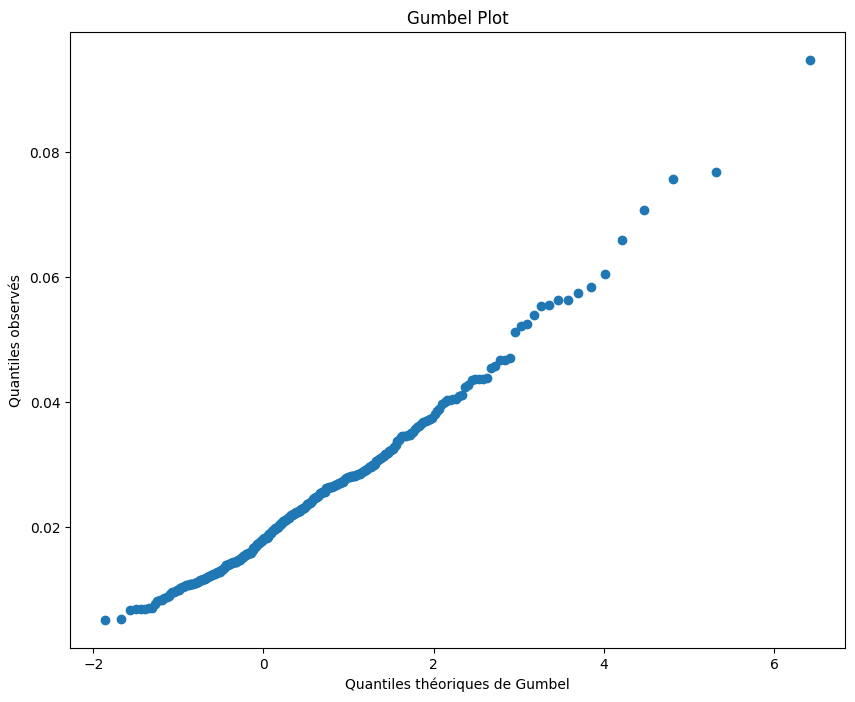

In [164]:
quantiles_theoriques_gumbel = []
for i in range(1,len(maxima_train_sample)+1):
    val = -np.log(-np.log((i-0.5)/len(maxima_train_sample)))
    quantiles_theoriques_gumbel.append(val)

# Tracer le Gumbel plot
plt.figure(figsize=(10, 8))
plt.scatter(quantiles_theoriques_gumbel, np.sort(maxima_train_sample), marker='o')
plt.title('Gumbel Plot')
plt.xlabel('Quantiles théoriques de Gumbel')
plt.ylabel('Quantiles observés')
plt.show()

Le Gumbel plot semble relativement linéaire. Ainsi il semble que l'hypothèse selon laquelle $\xi$ est nul soit acceptable. La distribution adaptée à nos données semble donc être une distribution de Gumbel.

In [165]:
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r

params_gev = gev.fit(maxima_train_sample)
params_gumbel = gumbel_r.fit(maxima_train_sample)

# Afficher les paramètres estimés
print("Paramètres estimés de la distribution GEV:")
print("Forme (xi) =", params_gev[0])
print("Localisation (mu) =", params_gev[1])
print("Echelle (sigma) =", params_gev[2])
print(150*"-")
print("Paramètres estimés de la distribution de Gumbel (xi nul):")
print("Localisation (mu) =", params_gumbel[0])
print("Echelle (sigma) =", params_gumbel[1])

Paramètres estimés de la distribution GEV:
Forme (xi) = -0.7725395136844684
Localisation (mu) = 0.017131692081872454
Echelle (sigma) = 0.01129503253185405
------------------------------------------------------------------------------------------------------------------------------------------------------
Paramètres estimés de la distribution de Gumbel (xi nul):
Localisation (mu) = 0.01869561313242568
Echelle (sigma) = 0.009313391888439576


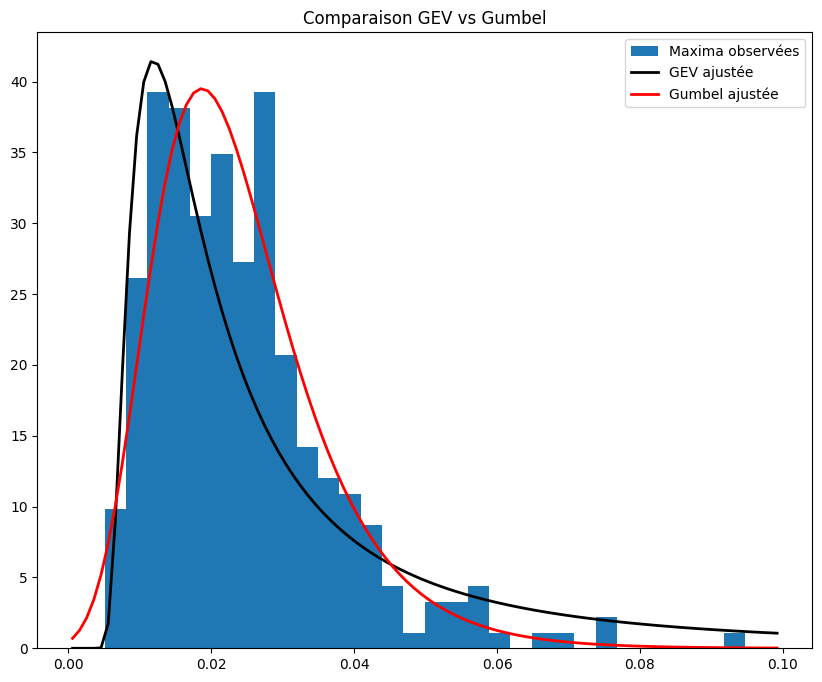

In [166]:
plt.figure(figsize=(10, 8))
plt.hist(maxima_train_sample, bins=30, density=True, label='Maxima observées')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Densité GEV ajustée
p_gev = gev.pdf(x, *params_gev)
plt.plot(x, p_gev, 'k', linewidth=2, label='GEV ajustée')

# Densité Gumbel ajustée
p_gumbel = gumbel_r.pdf(x, *params_gumbel)
plt.plot(x, p_gumbel, 'r', linewidth=2, label='Gumbel ajustée')

title = "Comparaison GEV vs Gumbel"
plt.title(title)
plt.legend()
plt.show()

On remarque la loi GEV ($\xi$ non nul) estimée a une queue plus lourde que la loi de Gumbel ($\xi$ nul) estimée. Toutefois, de manière générale, la distribution de Gumbel estimée semble plus coller à l'histogramme représenté.

In [167]:
niveaux_quantiles = np.arange(0.001,1, 0.001)
quantiles_empiriques_TVE = np.quantile(maxima_train_sample, niveaux_quantiles) 
quantiles_theoriques_GEV = gev.ppf(niveaux_quantiles, params_gev[0], loc = params_gev[1], scale = params_gev[2])
quantiles_theoriques_Gumb = gumbel_r.ppf(niveaux_quantiles, *params_gumbel)

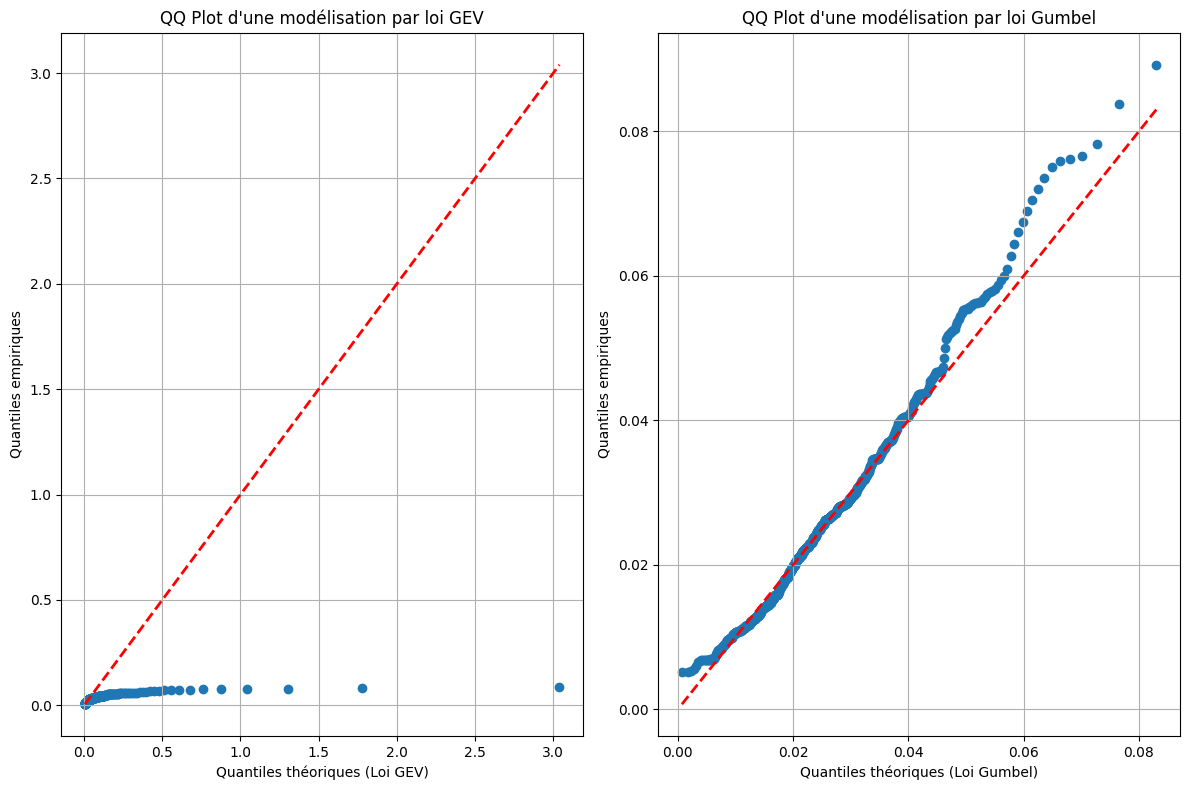

In [168]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(quantiles_theoriques_GEV, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_GEV, quantiles_theoriques_GEV, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi GEV")
plt.xlabel('Quantiles théoriques (Loi GEV)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)



plt.subplot(1, 2, 2)
plt.scatter(quantiles_theoriques_Gumb, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_Gumb, quantiles_theoriques_Gumb, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi Gumbel")
plt.xlabel('Quantiles théoriques (Loi Gumbel)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)

plt.tight_layout()
plt.show()

La modélisation par loi de Gumbel semble beaucoup mieux correspondre aux données. Cette distribution semble également satisfaisante au vu de l'adéquation avec les quantiles empiriques. Nous utilisons donc cette loi pour la suite.

### Calcul de la VAR 

In [169]:
alpha = 0.99
alpha_bm = 1-s*(1-alpha)
var_TVE_MB = -gumbel_r.ppf(alpha_bm, *params_gumbel)
print("VaR TVE par maxima par blocs : ", var_TVE_MB)

VaR TVE par maxima par blocs :  -0.03215440245153539


### Backtesting

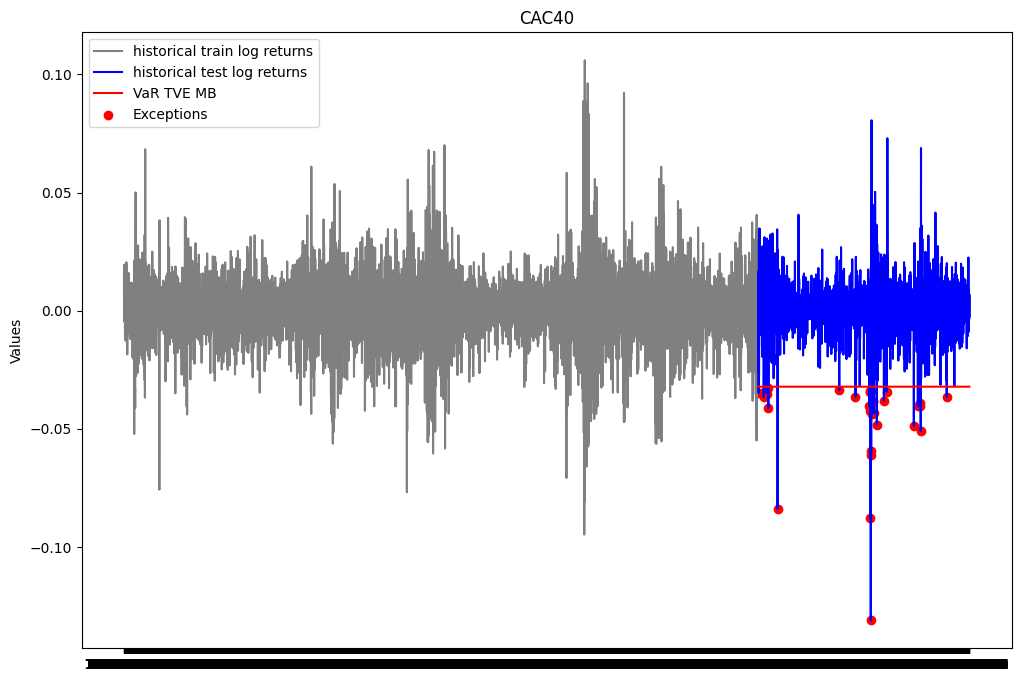

In [170]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index[0:train_size], train_close['log_return'], label="historical train log returns", color = 'gray')
plt.plot(ts_close.index[train_size:], test_close['log_return'], label="historical test log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], [var_TVE_MB for i in range(test_size)], label="VaR TVE MB", color = 'red')
list_exceptions_TVE_MB = [i for i in range(len(test_close['log_return'])) if test_close['log_return'].iloc[i]<var_TVE_MB]
plt.scatter(test_close.index[list_exceptions_TVE_MB], test_close['log_return'].iloc[list_exceptions_TVE_MB], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

In [171]:
print(f"Le nombre d'exceptions pour la VaR TVE maxima par blocs est: {len(list_exceptions_TVE_MB)}")
print(f"Le pourcentage d'exceptions pour la VaR TVE maxima par blocs est: {len(list_exceptions_TVE_MB)/test_size}")

Le nombre d'exceptions pour la VaR TVE maxima par blocs est: 32
Le pourcentage d'exceptions pour la VaR TVE maxima par blocs est: 0.014849187935034803


In [172]:
test_except_TVE_MB = stats.binomtest(len(list_exceptions_TVE_MB), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_TVE_MB.pvalue}')

la p-value du test binomial est: 0.029672279824551718


La p-value du test binomial est en dessous du seuil de 5%. On rejette donc l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%. Le modèle VaR TVE MB estimé ne semble donc pas satisfaisant.

# VAR TVE: Approche Peak over threshold

### Fonction pour le Mean Excess Plot

In [173]:
def mean_excess_plot(returns):
    sorted_returns =np.sort(returns)
    listeu = np.linspace(np.min(sorted_returns), np.max(sorted_returns), num = 1000)
    listeu = listeu[listeu < np.percentile(listeu, 80)] ## Retirer les valeurs trop extrêmes
    mean_excess = []
    n=len(sorted_returns)
    
    for u in listeu:
        if u > 0:
            terms = []
            NU=0
            for i in range(n):
                term = sorted_returns[i]-u
                terms.append(max(term,0))
                if term >0:
                    NU = NU + 1
            try:
                mean_excess.append( (1/NU) * np.sum(terms))
            except:
                listeu = listeu[listeu!=u]
        else:
            listeu = listeu[listeu!=u]
    
    plt.figure(figsize = (10,8))
    plt.plot(listeu, mean_excess)
    plt.title('Mean excess Plot')
    plt.ylabel('Moyenne des excès empirique')
    plt.xlabel('Seuils')
    plt.plot()
   

### Détermination de u par analyse graphique

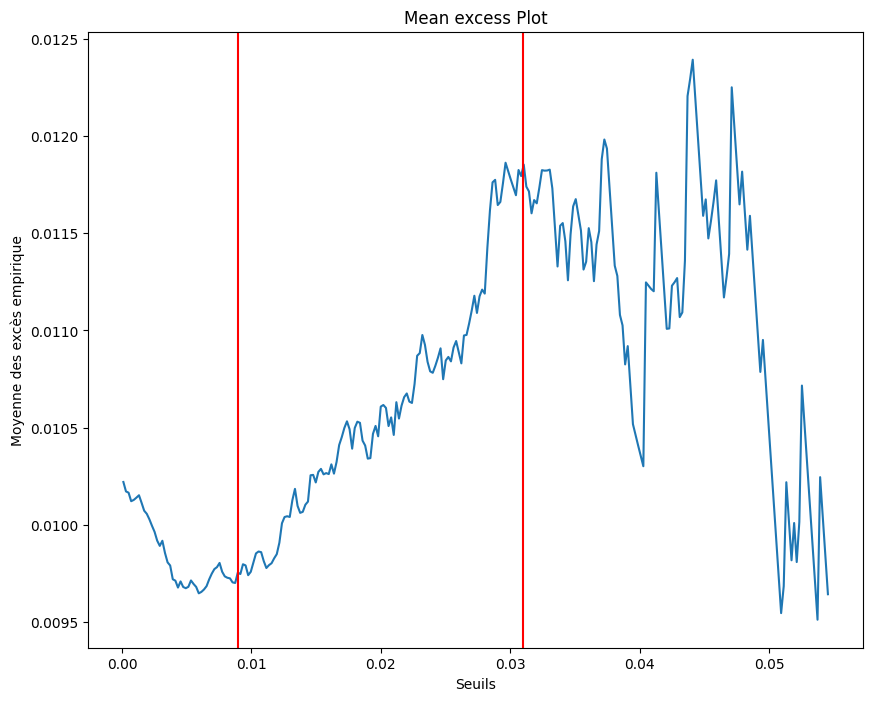

In [174]:
mean_excess_plot(minus_train_returns)
plt.axvline(x=0.009, color='red')
plt.axvline(x=0.031, color='red')
plt.show()

Par analyse graphique, nous pouvons garder u = 0.03

### Estimation des paramètres de la loi GPD

In [175]:
u = 0.03
excess_values = [value - u for value in minus_train_returns if value >= u]

In [176]:
from scipy.stats import genpareto

params_gpd = genpareto.fit(excess_values)

# Afficher les paramètres estimés
print("Paramètres estimés de la distribution GPD:")
print("Forme (xi) =", params_gpd[0])
print("Localisation (mu) =", params_gpd[1])
print("Echelle (sigma) =", params_gpd[2])


Paramètres estimés de la distribution GPD:
Forme (xi) = 1.400978075966914
Localisation (mu) = 0.00016228465968312747
Echelle (sigma) = 0.006479315921431309


### Validation Ex ante

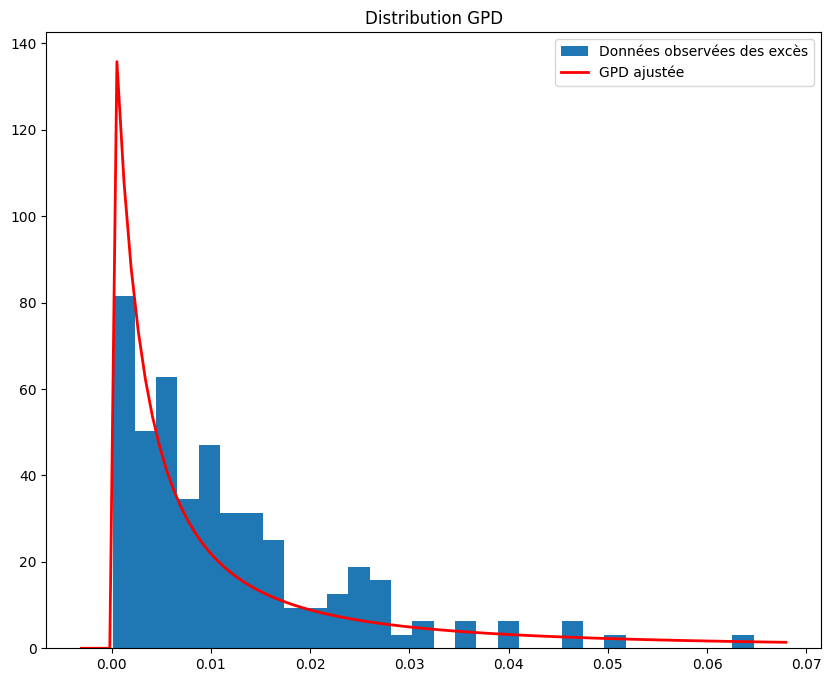

In [177]:
plt.figure(figsize=(10, 8))
plt.hist(excess_values, bins=30, density=True, label='Données observées des excès')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Densité GPD ajustée
p_gpd = genpareto.pdf(x, *params_gpd)
plt.plot(x, p_gpd, 'r', linewidth=2, label='GPD ajustée')


title = "Distribution GPD"
plt.title(title)
plt.legend()
plt.show()

Nous remarquons que la distribution GPD correspond relativement bien à notre distribution des excès.

In [178]:
niveaux_quantiles = np.arange(0.01, 1, 0.01)
quantiles_empiriques_POT = np.quantile(excess_values, niveaux_quantiles)
quantiles_theoriques_GDP = genpareto.ppf(niveaux_quantiles, *params_gpd)

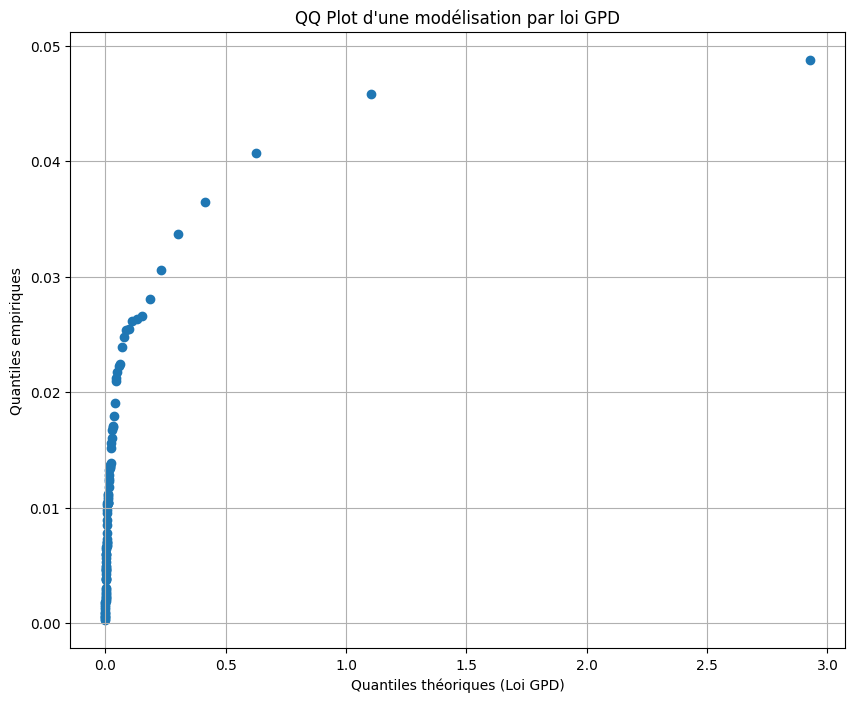

In [179]:
plt.figure(figsize=(10, 8))

plt.scatter(quantiles_theoriques_GDP, quantiles_empiriques_POT)
#plt.plot(quantiles_theoriques_GDP, quantiles_theoriques_GDP, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi GPD")
plt.xlabel('Quantiles théoriques (Loi GPD)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)


Le QQ plot estimé indique que les quantiles théoriques de la loi GPD sont beaucoup plus grands que les quantiles empiriques observés dans notre distribution des excès.

### Calcul de la VAR

In [180]:
alpha = 0.99
NU = len([term for term in minus_train_returns if term-u>0])
alpha_pot = 1-len(minus_train_returns)*(1-alpha)/NU
var_TVE_POT = -genpareto.ppf(alpha_pot, *params_gpd)-u
print("VaR TVE Peak Over Threshold : ",var_TVE_POT)

VaR TVE Peak Over Threshold :  -0.04030157916096224


### Backtesting

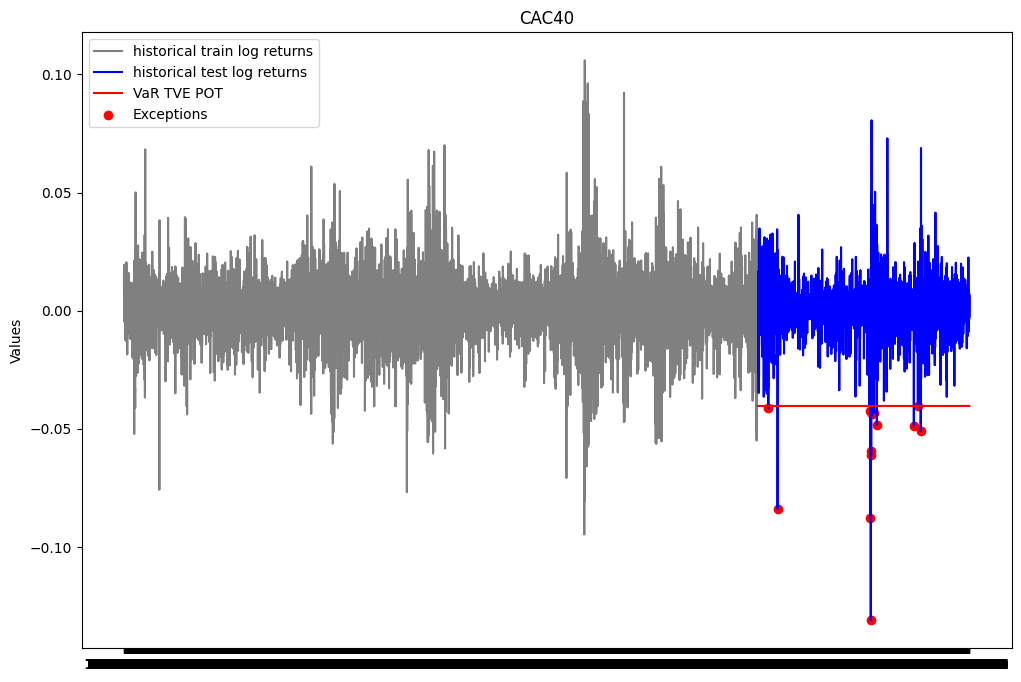

In [181]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index[0:train_size], train_close['log_return'], label="historical train log returns", color = 'gray')
plt.plot(ts_close.index[train_size:], test_close['log_return'], label="historical test log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], [var_TVE_POT for i in range(test_size)], label="VaR TVE POT", color = 'red')
list_exceptions_TVE_POT = [i for i in range(len(test_close['log_return'])) if test_close['log_return'].iloc[i]<var_TVE_POT]
plt.scatter(test_close.index[list_exceptions_TVE_POT], test_close['log_return'].iloc[list_exceptions_TVE_POT], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

In [182]:
print(f"Le nombre d'exceptions pour la VaR TVE Peak Over Threshold est: {len(list_exceptions_TVE_POT)}")
print(f"Le pourcentage d'exceptions pour la VaR TVE Peak Over Threshold est: {len(list_exceptions_TVE_POT)/test_size}")

Le nombre d'exceptions pour la VaR TVE Peak Over Threshold est: 14
Le pourcentage d'exceptions pour la VaR TVE Peak Over Threshold est: 0.0064965197215777265


In [183]:
test_except_TVE_POT = stats.binomtest(len(list_exceptions_TVE_POT), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_TVE_POT.pvalue}')

la p-value du test binomial est: 0.12764156708850183


La p-value du test binomial est au dessus du seuil de 5%. On ne peut donc pas rejeter l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%. Le modèle VaR TVE MB estimé semble donc satisfaisant.

# Comparaison des différentes approches 

In [222]:
dict_comp = {"Méthode" : ["VaR non paramétrique", "VaR Bootstrap non paramétrique", "VaR gaussienne", 'VaR Gaussienne EWMA (lambda =0.9)',
                                'VaR Gaussienne EWMA (lambda =0.95)','VaR Gaussienne EWMA (lambda =0.99)', "VaR dynamique", "VaR Skew Student", 
                                "VaR TVE MB", "VaR TVE POT"], 
                    "VaR": [var_hist, var_hist_boot, var_gaus, VaR1, VaR2, VaR3, None, var_skew, var_TVE_MB, var_TVE_POT],
                    "Nombre d'exceptions": [len(list_exceptions_np),len(list_exceptions_np_boot), len(list_exceptions_gaus),len(list_exceptions_gaus1),
                                            len(list_exceptions_gaus2),len(list_exceptions_gaus3),len(list_exceptions_dyn),len(list_exceptions_skew),
                                            len(list_exceptions_TVE_MB),len(list_exceptions_TVE_POT)],
                    "Taux d'exceptions": [len(list_exceptions_np)/test_size,len(list_exceptions_np_boot)/test_size, len(list_exceptions_gaus)/test_size,len(list_exceptions_gaus1)/test_size,
                                            len(list_exceptions_gaus2)/test_size,len(list_exceptions_gaus3)/test_size,len(list_exceptions_dyn)/len(vars_dyn),len(list_exceptions_skew)/test_size,
                                            len(list_exceptions_TVE_MB)/test_size,len(list_exceptions_TVE_POT)/test_size],
                    "P-value du test binomial": [round(test_except_np.pvalue,3),round(test_except_np_boot.pvalue,3), round(test_except_gaus.pvalue,3),
                                                round(test_except_gaus1.pvalue,3),round(test_except_gaus2.pvalue,3), round(test_except_gaus3.pvalue,3),
                                                round(test_except_dyn.pvalue,3), round(test_except_skew.pvalue,3),round(test_except_TVE_MB.pvalue,3), round(test_except_TVE_POT.pvalue,3)]}

pd.DataFrame(dict_comp)

,Méthode,VaR,Nombre d'exceptions,Pourcentage d'exceptions,P-value du test binomial
0,VaR non paramétrique,-0.043208,10,0.004640,0.009
1,VaR Bootstrap non paramétrique,-0.039931,16,0.007425,0.278
2,VaR gaussienne,-0.034733,25,0.011601,0.328
3,VaR Gaussienne EWMA (lambda =0.9),-0.047136,8,0.003712,0.002
4,VaR Gaussienne EWMA (lambda =0.95),-0.046886,8,0.003712,0.002
5,VaR Gaussienne EWMA (lambda =0.99),-0.035612,23,0.010673,0.744
6,VaR dynamique,NaN,133,0.015896,0.000
7,VaR Skew Student,-0.039652,16,0.007425,0.278
8,VaR TVE MB,-0.032154,32,0.014849,0.030
9,VaR TVE POT,-0.040302,14,0.006497,0.128


## Commentaires 

Nous avons estimé jusque là 10 valeurs différentes de la VaR. Ces différentes valeurs estimées correspondent à des approches différentes. Nous avons à chaque fois estimer une VaR 99% à horizon 1 jour. Le taux d'exceptions attendu afin de juger de la bonne qualité de la VaR est de 1%.
- La VaR dynamique est particulière car, comme son nom l'indique, elle est dynamique donc pas constante au cours du temps. Elle a plus d'exceptions car elle est testée sur plus de données que les autres VaRs. Toutefois son taux d'exceptions se rapproche de celui des autres VaRs.
- Le test binomial fournit une p-value inférieure au seuil de 5% pour les VaRs non paramétrique, Gaussienne EWMA ($\lambda$ = 0.9 et $\lambda$ = 0.95), dynamique et TVE par maxima par blocs. Ce qui sous entend que le taux d'exception est statistiquement différent du taux attendu de 1%. On en déduit donc que les modèles utilisés sont peu adéquats pour nos données.
- La VaR non paramétrique et les VaR Gaussiennes EWMA pour $\lambda$ faible ont tendance à sous estimer la VaR tandis que la VaR dynamique et la VaR TVE par maxima par blocs ont tendance à sur estimer la vraie valeur de la VaR
- De plus, la validation ex-ante de la VaR TVE POT nous indique une inadéquation entre les quantiles théoriques et les quantiles empiriques des excès. 
- Nous avons également montré que la VaR Skew Student semblait nettement plus valide que la VaR gaussienne. Toutefois, nous avons également estimé une amélioration de la VaR gaussienne qui est la VaR gaussienne pondérée par la méthode EWMA. 
- Les VARs qui nous semblent donc les plus pertinentes sont la VaR Bootstrap non paramétrique, la VaR gaussienne EWMA ($\lambda$=0.99) et la VaR Skew Student.

# Calcul de la VaR en utilisant un modèle AR-GARCH

Dans les modélisations précédentes, nous avons supposé que les rendements avaient une moyenne constante au cours du temps, une volatilité constante et qu'elles sont non auto-correlées. Cependant, ces hypothèses ne sont pas vérifiées dans la réalité. En effet, les rendements connaissent des périodes relativement stable et des périodes de volatilité élevée. De plus, les rendements sont auto-corrélés. Pour prendre en compte ces caractéristiques, nous allons modéliser les rendements par un modèle AR-GARCH.

Nous savons déjà que la série des log rendements est stationnaire. De plus les fonctions d'autocorrélation et d'autocorrélation partielle sont exponentielles décroissantes et s'annulent après quelques retards. Cela nous conduit à envisager un modèle AR(p) avec p=1,2,3,4,5,6,7,8,9,10. Nous allons comparer les modèles AR(p) et choisir le modèle qui minimise le BIC.

In [184]:
# Construction des modèles AR(p) for p in [1,2,3,4,5] et choix du modèle avec le plus petit BIC

from statsmodels.tsa.ar_model import AutoReg

bic = {}
for p in range(1,6):
    model = AutoReg(train_close['log_return'],lags=p).fit()
    bic[p] = model.bic

print(f"le modèle avec le plus petit BIC est le modèle AR({min(bic, key=bic.get)})")

le modèle avec le plus petit BIC est le modèle AR(1)


Le modèle AR(1) est celui qui a le plus petit BIC. Nous maintenant étudier l'adéquation de ce modèle.

#### Analyse des résidus 

Nous allons allons vérifier à l'aide du test de portemanteau si les résidus sont des bruits blancs. Nous utiliserons le test de Ljung-Box. L'hypothèse nulle est qu'il n'existe pas d'autocorrélation dans les résidus.

In [185]:
# Test de Ljung-Box pour les résidus du modèle AR(1)

from statsmodels.stats.diagnostic import acorr_ljungbox

model = AutoReg((train_close['log_return']-np.mean(train_close['log_return'])),lags=1).fit()
residus = model.resid
result_lyung_box = acorr_ljungbox(residus, lags=10)
result_lyung_box
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:             log_return   No. Observations:                 6463
Model:                     AutoReg(1)   Log Likelihood               18394.879
Method:               Conditional MLE   S.D. of innovations              0.014
Date:                Sat, 10 Feb 2024   AIC                         -36783.758
Time:                        21:16:34   BIC                         -36763.437
Sample:                             1   HQIC                        -36776.727
                                 6463                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -2.31e-06      0.000     -0.013      0.989      -0.000       0.000
log_return.L1    -0.0092      0.012     -0.741      0.458      -0.034       0.015
                                    Root

Il est en resort que l'hypothèse nulle du test rejettée pour les 10 premiers lags, ce qui signifie que les résidus 
sont corrélés. Nous pouvons déjà conclure que le modèle AR(1) n'est pas satisfaisant. L'homoscédasticité des résidus peut être vérifiée aussi à l'aide du test de Portemanteau : en étudiant la corrélation des carrés des résidus.
Nous pouvons aussi étudier la normalité des résidus à l'aide du test de Jarque-Bera et du QQ plot. 


#### Test de Portemanteau sur les carrés des résidus

In [186]:

result_lyung_box = acorr_ljungbox(residus**2, lags=10)
print(  result_lyung_box) 

        lb_stat      lb_pvalue
1    231.697585   2.541754e-52
2    593.531949  1.306697e-129
3    948.626672  2.507727e-205
4   1230.399166  4.092016e-265
5   1695.949057   0.000000e+00
6   1920.095157   0.000000e+00
7   2117.633776   0.000000e+00
8   2312.473230   0.000000e+00
9   2587.570093   0.000000e+00
10  2884.923907   0.000000e+00


L'hypothèse nulle qui suppose que les résidus sont homoscédastiques est rejetée. Nous pouvons donc conclure que les résidus ne sont pas homoscédastiques et pensez à un modèle GARCH sur les résidus.

### QQ plot des résidus

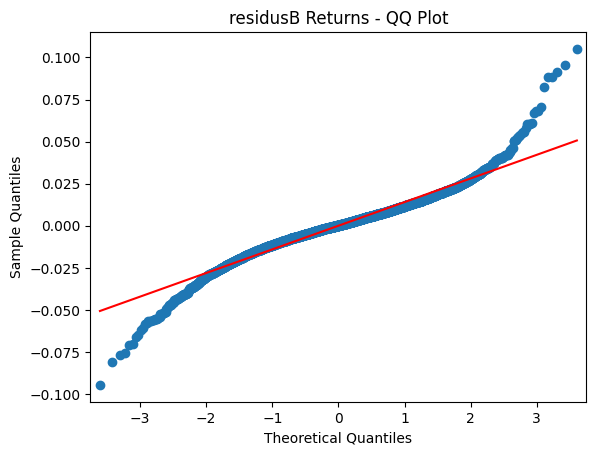

In [187]:

import matplotlib.pyplot as plt
import statsmodels.api as sm


sm.qqplot(residus, line ='s')
plt.title('residusB Returns - QQ Plot')
plt.show()

#### Test de Jarque-Bera

In [188]:
from scipy.stats import jarque_bera

# Test de Jarque-Bera pour la normalité
jb_test_statistic, jb_p_value = jarque_bera(residus)
print("Jarque-Bera test statistic:", jb_test_statistic)
print("Jarque-Bera test p-value:", jb_p_value)

Jarque-Bera test statistic: 5247.415969035655
Jarque-Bera test p-value: 0.0


On peut déjà constater à partir de ce qqplot que les résidus ne suivent pas une loi normale. En effet, les quantiles théoriques et les quantiles empiriques ne sont pas alignés. Nous avons également rejeté l'hypothèse nulle du test de Jarque-Bera.

Nous allons maintenant modéliser le résidus de ce AR(1).

### Adéquation du modèle GARCH sur les résidus

Afin de vérifier si le modèle GARCH est adéquat pour les résidus, nous allons ajuster un modèle GARCH(1,1) aux résidus et ensuite nous allons vérifier à partir des résidus au carrée s'il y'a de l'hetéroscedasticité dans les résidus.

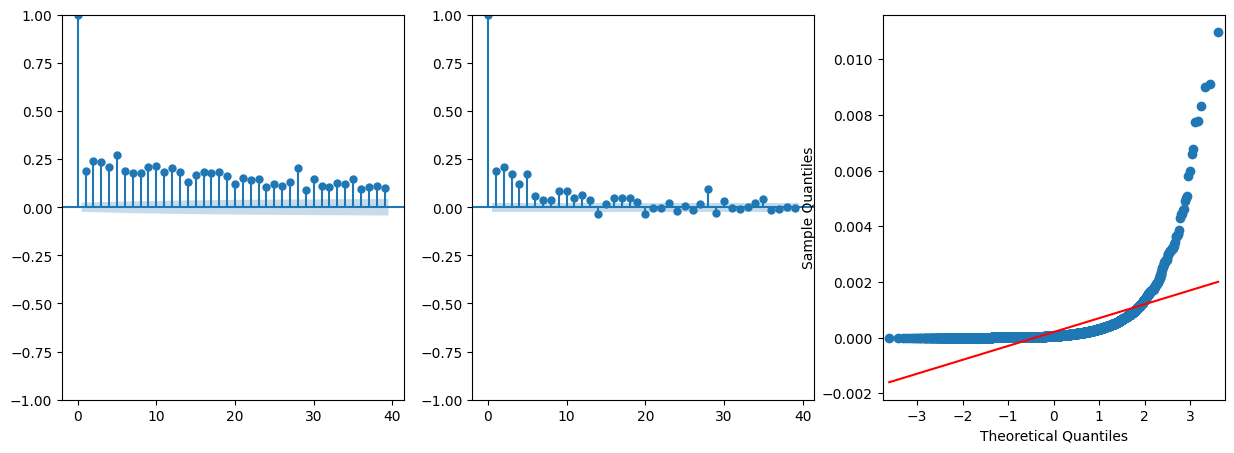

In [189]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Fit the GARCH(1,1) model in the résidus and take the square

residus_garch_model = arch_model(residus, vol='Garch', p=1, q=1).fit(disp='off')
residuals_garch = residus_garch_model.resid
squared_residuals_garch = residuals_garch**2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_acf(squared_residuals_garch, ax=axes[0], title="")
plot_pacf(squared_residuals_garch, ax=axes[1], title="")
sm.qqplot(squared_residuals_garch, line ='s',ax=axes[2])    

plt.show()

Le graphique ci-dessous confirme la présence d'hetéroscedasticité dans les résidus. Nous pouvons donc conclure que le modèle GARCH est adéquat pour les résidus. Appliquons dons un modèle GARCH(1,1) aux résidus et voyons ses résultats.
Nous allons procéder par étape :

- Nous allons itérer sur les modèles ARIMA(p,d,q) pour trouver le modèle qui minimise le BIC.
- Nous allons prendre le modèle GARCH(p,q) en fonction du modèle ARIMA(p,d,q) qui minimise le BIC.
- Appliquer le modèle GARCH(p,q) aux résidus et examiner les résidus du modèle et les résidus du modèle au carré pour vérifier la présence d'hetéroscedasticité.

Avant d'aller plus loin, vérifions statistiquement la présence d'un effet ARCH dans les résidus.

In [190]:
## Test d'un effet ARCH sur les résidus

import statsmodels.api as sm

arch_test = sm.stats.diagnostic.het_arch(squared_residuals_garch)

print(f'ARCH test results:\n')
print(f'LM Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')
print(f'F Statistic: {arch_test[2]}')
print(f'p-value: {arch_test[3]}')

ARCH test results:

LM Statistic: 624.9569659306129
p-value: 7.887973949362182e-128
F Statistic: 69.08045459804893
p-value: 1.2818085014330244e-134


Nous pouvons conclure qu'il y'a un effet ARCH dans les résidus. Nous allons donc appliquer un modèle GARCH(1,1) aux résidus pour capturer la volatilité. L'hypothèse d'homoscédasticité est rejetée.  Donc il y'a une présence d'hétéroscédasticit conditionnelle dans les résidus.

## Modélisation du GARCH sur les résidus. 

Nous allons appliquer un modèle GARCH(1,1) sur les résidus. 

In [191]:
garch_final_model = arch_model(residus, vol='Garch', p=1, q=1).fit(disp='off')
print(garch_final_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                19233.9
Distribution:                  Normal   AIC:                          -38459.7
Method:            Maximum Likelihood   BIC:                          -38432.6
                                        No. Observations:                 6462
Date:                Sat, Feb 10 2024   Df Residuals:                     6461
Time:                        21:16:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.3553e-04  7.461e-06     44.969      0.000 [3.

Les résultats du modèle GARCH(1,1) se trouvent dans le tableau ci-dessus. Nous pouvons constater que les paramètres sont tous significatifs. Nous allons maintenant vérifier la qualité d'ajustement du modèle GARCH(1,1) aux résidus.

#### Analyse des résidus du modèle GARCH

La figure ci-dessous représente les différents graphiques :
- Le graphique des résidus du modèle GARCH
- La volatilité conditionnelle estimée
- Le graphique des résidus standardisés

Le résidu dont l'analyse de la blancheur nous intéresse est le résidu standardisé. Il est le résultat du rapport entre le résidu du modèle GARCH et la volatilité conditionnelle estimée. Nous allons donc vérifier si ce résidu est un bruit blanc. C'est ce résidu que nous allons utiliser pour modéliser la VaR.

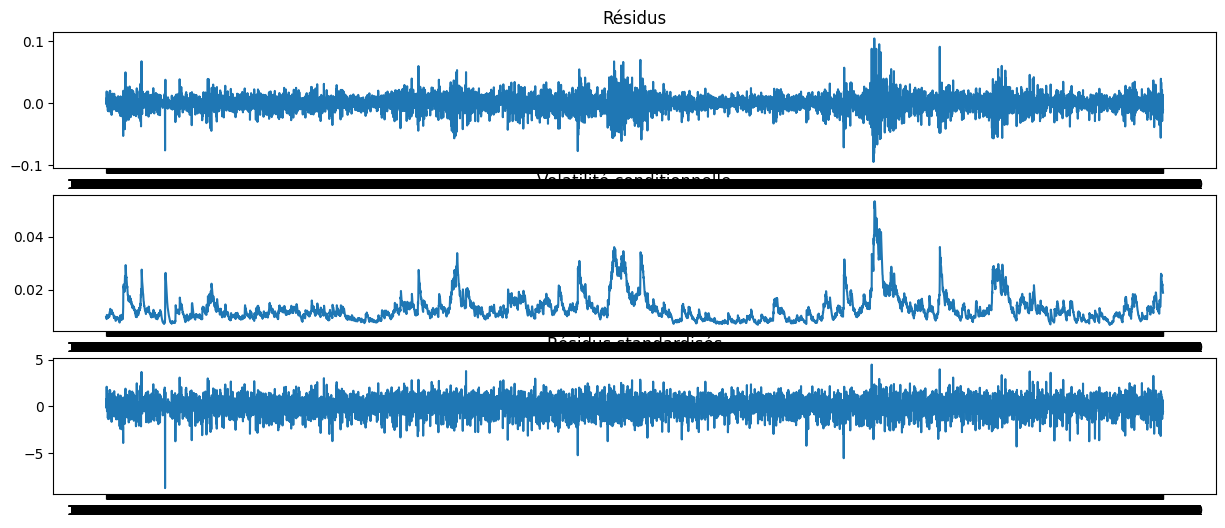

In [192]:
std_residus = garch_final_model.resid / garch_final_model.conditional_volatility
fig, axes = plt.subplots(3, 1, figsize=(15, 6))


axes[0].plot(garch_final_model.resid)
axes[0].set_title("Résidus")
axes[1].plot(garch_final_model.conditional_volatility)
axes[1].set_title("Volatilité conditionnelle")
axes[2].plot(std_residus)
axes[2].set_title("Résidus standardisés")

plt.show()


### Vérifions que les résidus de ce modèle GARCH sont des bruits blancs.

Nous allons faire le test de Ljung-Box pour vérifier l'autocorrélation des résidus. Et nous allons également faire ce test sur les carrés des résidus pour vérifier l'absence d'autocorrélation des résidus au carré d'où l'absence d'hetéroscedasticité.

In [193]:
# test de Ljung-Box sur les résidus et les résidus au carré

test_lyungbow = acorr_ljungbox(std_residus, lags=[10], return_df=False)
print(test_lyungbow)
test_lyungbow_squared = acorr_ljungbox(std_residus**2, lags=[10], return_df=False)
print(test_lyungbow_squared)

      lb_stat  lb_pvalue
10  15.733691   0.107514
     lb_stat  lb_pvalue
10  9.253333   0.508242


Dans les deux cas, la p-value est supèrieur à 5%. Nous ne pouvons donc pas rejeter l'hypothèse nulle selon laquelle les résidus sont des bruits blancs. Nous pouvons donc conclure que le modèle GARCH(1,1) est satisfaisant. Nous pouvons faire d'autres tests pour vérifier la qualité de notre modèle tel que le test de Jarque-Bera et le QQ plot.

Les estimations des paramètres du modèle AR(1)-GARCH(1,1) sont significatifs. Nous pouvons donc conclure que le modèle AR(1)-GARCH(1,1) est adéquat pour les log-rendements.
Les paramètres estimés sont :
- alpha = 0.0858
- beta = 0.8978
- omega = 0.0322
- phi =  -0.0092    


## Estimation des paramètres du modèle AR(1)-GARCH(1,1).

Nous pouvons directement estimer les paramètres du modèle AR(1)-GARCH(1,1) en utilisant la fonction arch_model de la bibliothèque arch. C'est ce que nous allons faire dans la cellule suivante.

In [194]:
## estimation des paramètres du modèle AR(1) -GARCH(1,1)

ar_garch_model = arch_model(train_close['log_return'], vol='Garch', p=1, q=1, mean='AR', lags=1).fit(disp='off')
print(ar_garch_model.summary())

                           AR - GARCH Model Results                           
Dep. Variable:             log_return   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                19233.9
Distribution:                  Normal   AIC:                          -38457.7
Method:            Maximum Likelihood   BIC:                          -38423.9
                                        No. Observations:                 6462
Date:                Sat, Feb 10 2024   Df Residuals:                     6460
Time:                        21:20:13   Df Model:                            2
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          4.7602e-04  2.667e-05     17

In [195]:
# les paramètres du modèle AR(1)-GARCH(1,1) sont les suivants

print(f"Les paramètres du modèle AR(1)-GARCH(1,1) sont les suivants:\n{ar_garch_model.params}")
constance,phi, omega, alpha, beta = ar_garch_model.params

Les paramètres du modèle AR(1)-GARCH(1,1) sont les suivants:
Const            0.000476
log_return[1]   -0.009226
omega            0.000004
alpha[1]         0.100000
beta[1]          0.880000
Name: params, dtype: float64


Les résultats ci-dessus donnent les mêmes résultats que ceux obtenus précédemment. Nous pouvons donc conclure que le modèle AR(1)-GARCH(1,1) est adéquat pour les log-rendements.

# Reproduction de la dynamique historique de $\sigma_t$ et de $\mu_t$

In [196]:
import numpy as np

def forcast_mu_sigma(r, phi_hat, omega_hat, alpha_hat, beta_hat):
    """
    Calcule les prévisions de mu et sigma^2 pour une série de log-rendements
    
    :param r: Vecteur de log-rendements (numpy array).
    :param phi_hat: Estimation de phi (float).
    :param omega_hat: Estimation de omega (float).
    :param alpha_hat: Estimation de alpha (float).
    :param beta_hat: Estimation de beta (float).
    :return: Tuple de numpy arrays (mu_hat, sigma2_hat).
    """
    
    # Initialisation des vecteurs mu_hat et sigma2_hat
    mu_hat = np.zeros(len(r))
    sigma2_hat = np.zeros(len(r))
    
    # Initialisation de la première valeur de mu_hat
    mu_hat[0] = np.mean(r)
    
    
    # Initialisation de la première valeur de sigma2_hat en utilisant la variance long terme
    sigma2_hat[0] = omega_hat / (1 - alpha_hat - beta_hat)
    
    # Calcul des valeurs de mu_hat et sigma2_hat en utilisant les formules GARCH(1,1)
    for t in range(1, len(r)):
        mu_hat[t] = mu_hat[0] + phi_hat * r[t-1]
        sigma2_hat[t] = omega_hat + alpha_hat * (r[t-1] - mu_hat[t-1])**2 + beta_hat * sigma2_hat[t-1]
    
    return mu_hat, sigma2_hat

constance,phi, omega, alpha, beta = ar_garch_model.params
mu_hat, sigma2_hat =forcast_mu_sigma(ts_close['log_return'],ar_garch_model.params['log_return[1]'], ar_garch_model.params['omega'], ar_garch_model.params['alpha[1]'], ar_garch_model.params['beta[1]'])




Une fois que l'on a reproduire la dynamique de $\sigma_t$ et de $\mu_t$, nous pouvons faire des représentations graphiques pour vérifier la qualité de cette reproduction. Dans le graphique ci-dessous, nous allons représenter la série de $\sigma_t$ et de $\mu_t$ en fonction de la date ainsi que la volatilité conditionnelle estimée par le modèle AR(1)-GARCH(1,1).

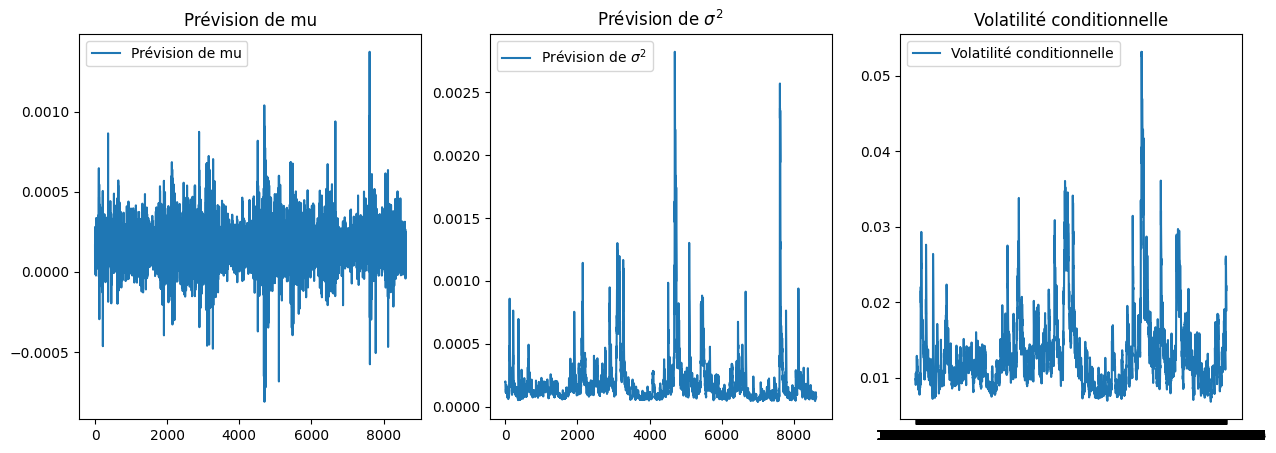

In [197]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot( mu_hat, label='Prévision de mu')
axes[0].set_title('Prévision de mu')
axes[0].legend()
axes[1].plot( sigma2_hat, label='Prévision de $\sigma^2$')
axes[1].set_title('Prévision de $\sigma^2$')
axes[1].legend()
axes[2].plot(garch_final_model.conditional_volatility, label='Volatilité conditionnelle')
axes[2].set_title('Volatilité conditionnelle')
axes[2].legend()


Avant de calculer la VaR dynamique, nous allons estimer le quantile de $1-\alpha$ des résidus $\epsilon_t$. Rappelons que notre modèle AR(1)-GARCH(1,1) est donné par :

L'équation du modèle AR(1) pour la moyenne conditionnelle :
$$\hat{\mu_t} = \hat{\mu} + \hat{\phi} R_{t-1}$$

L'équation du modèle GARCH(1,1) pour la variance conditionnelle :
$$\hat{\sigma_t}^2 = \hat{\omega} + \hat{\alpha} (R_{t-1} - \hat{\mu_t})^2 + \hat{\beta} \hat{\sigma_{t-1}}^2$$

où :
- $\hat{\mu_t}$ est la moyenne conditionnelle au temps $t$,
- $R_{t-1}$ est le rendement à $t-1$,
- $\hat{\sigma_t}^2$ est la variance conditionnelle au temps $t$,
- $\hat{\mu}$, $\hat{\phi}$, $\hat{\omega}$, $\hat{\alpha}$, et $\hat{\beta}$ sont les paramètres estimés du modèle.

Et enfin le résidu $\epsilon_t$ est donné par :

$$\epsilon_t = \frac{R_t - \hat{\mu_t}}{\hat{\sigma_t}}$$
qui est le résidu standardisé.

### Calcul de la VaR sur les résidus standardisés $\epsilon_t$

Pour calculer la VaR sur les résidus standardisés, nous allons utiliser pour l'approche non-paramétrique, la VaR historique boostrap et pour la méthode TVE, nous allons utiliser l'approche maxima par bloc.

# VaR historique boostrap sur les résidus standardisés et calcul de la VaR dynamique

In [198]:
### VaR historique bootstrap sur les résidus du modèle AR(1)-GARCH(1,1)

seuil = 0.99
seuil_IC = 0.9
num_simulations = 5000
n_B = 251*10 #on utilise 10 ans de données comme taille d'échantillons bootstrap

var_residu_boostrap = VaR_Hist_Bootstrap(std_residus, seuil, num_simulations, seuil_IC, n_B)[0]

var_garchdyn_boostrap = (mu_hat + np.sqrt(sigma2_hat) * var_residu_boostrap)


# Backtesting

In [199]:
list_exceptions_garchdyn_boot = [i for i in range(train_size,len(ts_close['log_return'])) if ts_close['log_return'][i]<var_garchdyn_boostrap[i]]
len(list_exceptions_garchdyn_boot)

26

In [200]:
print(f"Le nombre d'exceptions pour la VaR GARCH est: {len(list_exceptions_garchdyn_boot)}")
print(f"Le pourcentage d'exceptions pour la VaR GARCH est: {len(list_exceptions_garchdyn_boot)/test_size*100.:0.2f}%")

Le nombre d'exceptions pour la VaR GARCH est: 26
Le pourcentage d'exceptions pour la VaR GARCH est: 1.21%


In [201]:
test_except_gaus = stats.binomtest(len(list_exceptions_garchdyn_boot), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_gaus.pvalue:.2f}')

la p-value du test binomial est: 0.33


La pvalue du test est supérieure au seuil de 5%. On ne peut donc pas rejeter l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%. Nous concluons donc que notre VaR est satisfaisante. 

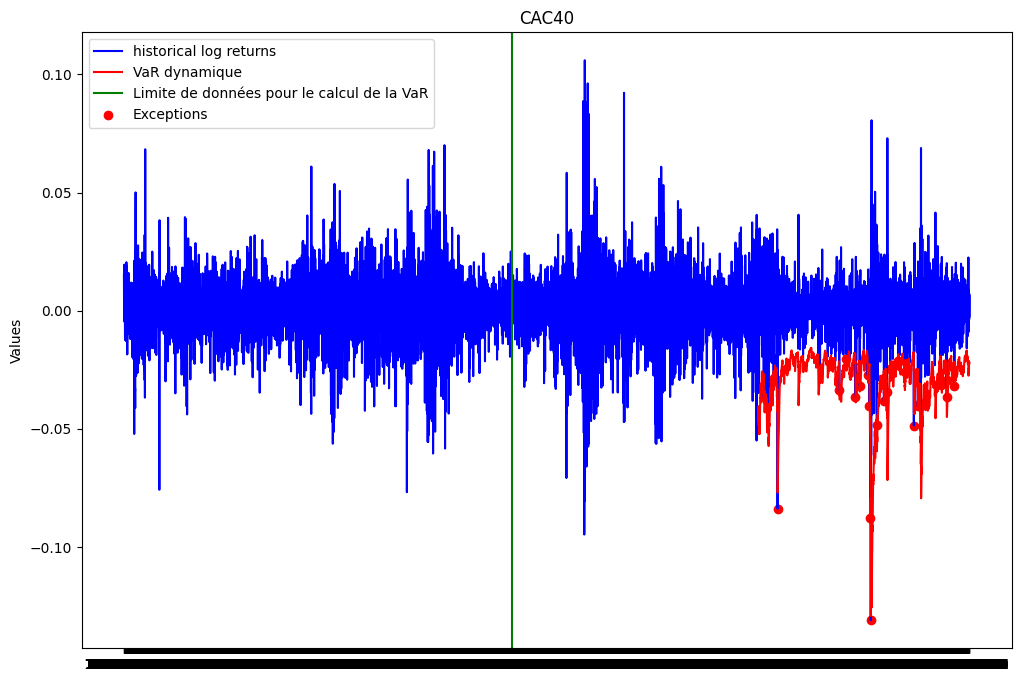

In [202]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index, ts_close['log_return'], label="historical log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], var_garchdyn_boostrap[train_size:], label='VaR dynamique', color = 'red')
plt.axvline(x = ts_close.index[train_size-251*10-1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
plt.scatter(ts_close.index[list_exceptions_garchdyn_boot], ts_close['log_return'][list_exceptions_garchdyn_boot], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

# VaR par la méthode maxima par bloc sur les résidus standardisés et calcul de la VaR dynamique

La TVE s'intéressant aux queues de distribution droite, nous allons d'abord convertir les résidus standardisés en prenant l'opposé.


In [203]:
std_residus_minus = -std_residus

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


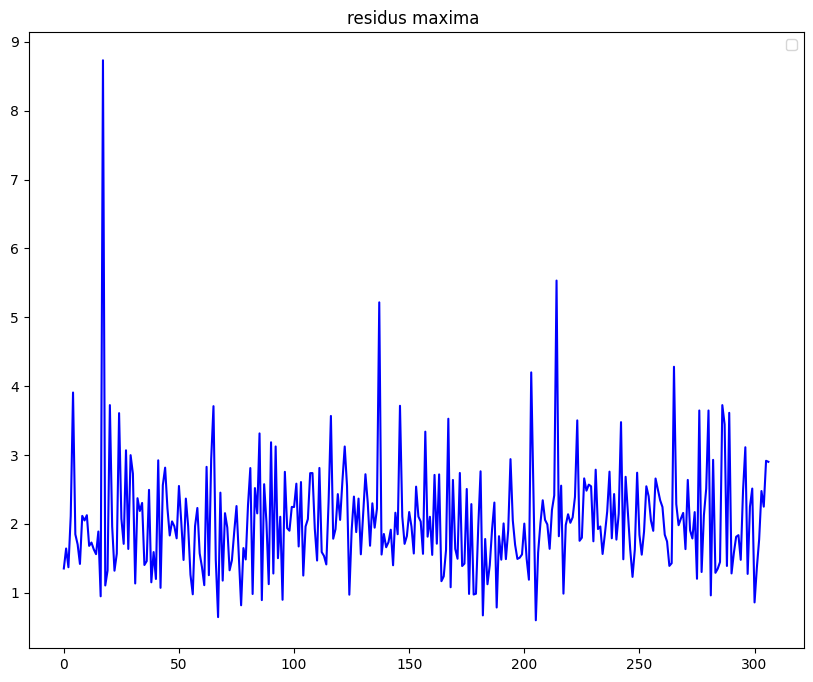

In [204]:

std_residus_maxima = construct_max_data(std_residus_minus, 21)

plt.figure(figsize=(10, 8))
plt.plot(std_residus_maxima ,color = 'blue')
plt.title("residus maxima ")
plt.plot()
plt.legend()
plt.show()

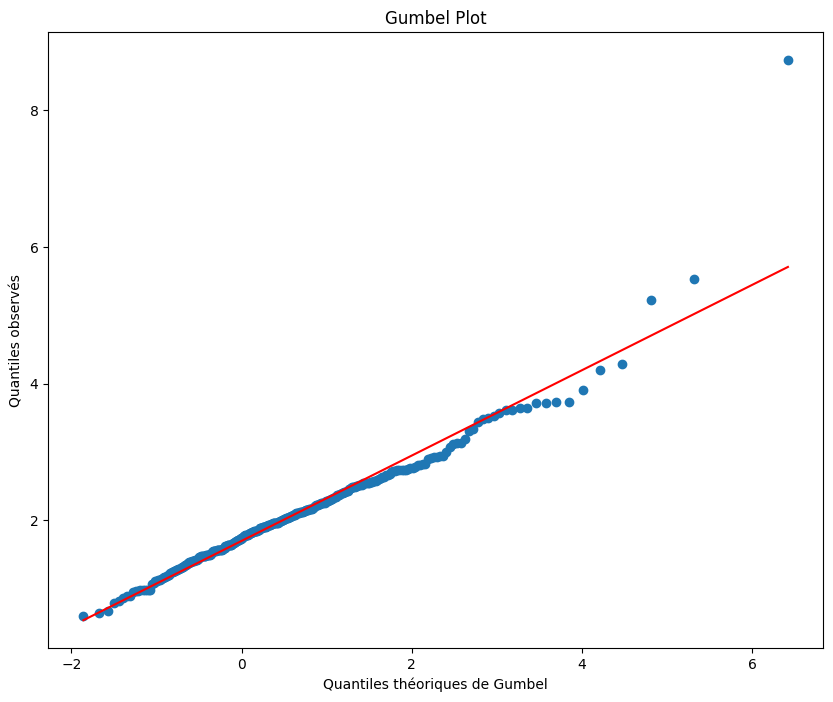

In [205]:
quantiles_theoriques_gumbel_residus = []
for i in range(1,len(std_residus_maxima)+1):
    val = -np.log(-np.log((i-0.5)/len(std_residus_maxima)))
    quantiles_theoriques_gumbel_residus.append(val)
    
# Tracer le Gumbel plot
plt.figure(figsize=(10, 8))
plt.scatter(quantiles_theoriques_gumbel_residus, np.sort(std_residus_maxima), marker='o')

# Étape 1 : Calculer les coefficients de la droite d'ajustement
coefficients = np.polyfit(quantiles_theoriques_gumbel_residus, np.sort(std_residus_maxima), 1)

# Étape 2 : Générer les valeurs de la droite d'ajustement
droite_ajustement = np.poly1d(coefficients)
x = np.array(quantiles_theoriques_gumbel_residus)
y_ajustement = droite_ajustement(x)

# Étape 3 : Tracer la droite d'ajustement
plt.plot(x, y_ajustement, color='red')

plt.title('Gumbel Plot')
plt.xlabel('Quantiles théoriques de Gumbel')
plt.ylabel('Quantiles observés')
plt.show()

Le gumbel plot  semble  linéaire et ne présente pas de courbure. Nous allons donc utiliser la loi de Gumbel pour la suite.

In [206]:
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r

params_gev_residus = gev.fit(std_residus_maxima)
params_gumbel_residus = gumbel_r.fit(std_residus_maxima)

# Afficher les paramètres estimés
print("Paramètres estimés de la distribution GEV:")
print("Forme (xi) =", params_gev_residus[0])
print("Localisation (mu) =", params_gev_residus[1])
print("Echelle (sigma) =", params_gev_residus[2])
print(150*"-")
print("Paramètres estimés de la distribution de Gumbel (xi nul):")
print("Localisation (mu) =", params_gumbel_residus[0])
print("Echelle (sigma) =", params_gumbel_residus[1])


Paramètres estimés de la distribution GEV:
Forme (xi) = -0.023456008571750273
Localisation (mu) = 1.7068601969202493
Echelle (sigma) = 0.5951776042334704
------------------------------------------------------------------------------------------------------------------------------------------------------
Paramètres estimés de la distribution de Gumbel (xi nul):
Localisation (mu) = 1.7147295823748347
Echelle (sigma) = 0.5991954595342129


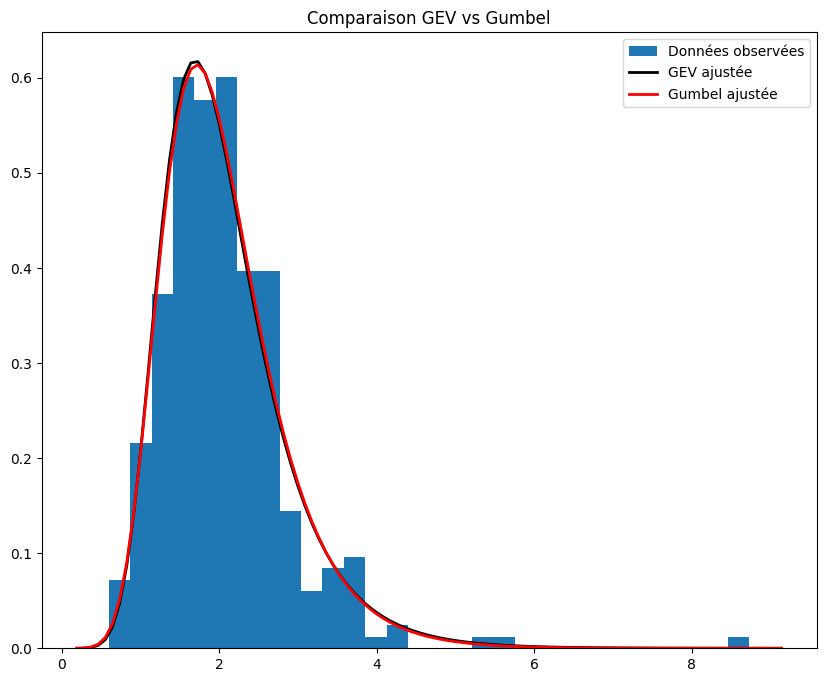

In [207]:
# Comparaison des distributions GEV et Gumbel

plt.figure(figsize=(10, 8))
plt.hist(std_residus_maxima, bins=30, density=True, label='Données observées')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Densité GEV ajustée
p_gev_residus = gev.pdf(x, *params_gev_residus)
plt.plot(x, p_gev_residus, 'k', linewidth=2, label='GEV ajustée')

# Densité Gumbel ajustée
p_gumbel_residus = gumbel_r.pdf(x, *params_gumbel_residus)
plt.plot(x, p_gumbel_residus, 'r', linewidth=2, label='Gumbel ajustée')

plt.title('Comparaison GEV vs Gumbel')
plt.legend()
plt.show()


Les deux distributions semblent bien modéliser la queue de distribution des résidus standardisés. 

In [208]:
niveaux_quantiles_residus = np.arange(0.001, 1, 0.001)
quantiles_empiriques_TVE_residus = np.quantile(std_residus_maxima, niveaux_quantiles_residus)
quantiles_theoriques_GEV_residus = gev.ppf(niveaux_quantiles_residus, *params_gev_residus)
quantiles_theoriques_Gumb_residus = gumbel_r.ppf(niveaux_quantiles_residus, *params_gumbel_residus)


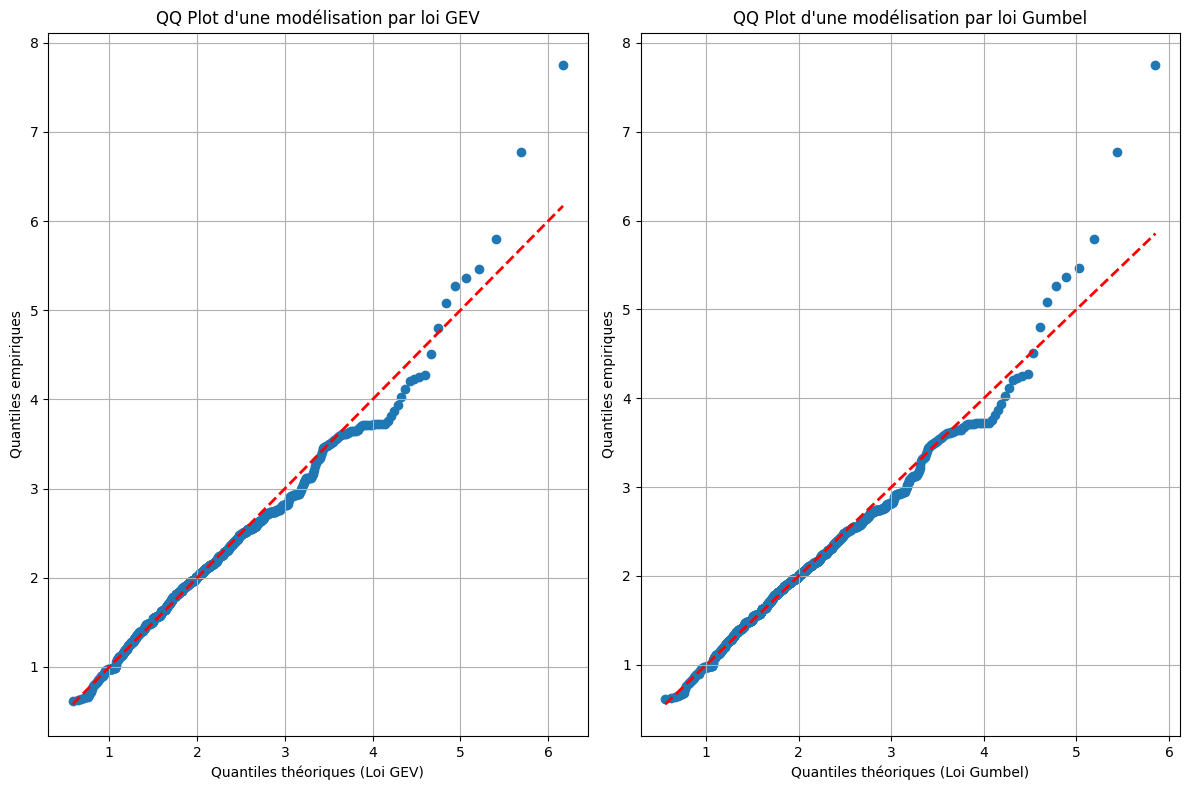

In [209]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(quantiles_theoriques_GEV_residus, quantiles_empiriques_TVE_residus)
plt.plot(quantiles_theoriques_GEV_residus, quantiles_theoriques_GEV_residus, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi GEV")
plt.xlabel('Quantiles théoriques (Loi GEV)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(quantiles_theoriques_Gumb_residus, quantiles_empiriques_TVE_residus)
plt.plot(quantiles_theoriques_Gumb_residus, quantiles_theoriques_Gumb_residus, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi Gumbel")
plt.xlabel('Quantiles théoriques (Loi Gumbel)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)

plt.tight_layout()
plt.show()

Les deux modélisations semblent bien correspondre aux données. Comme le Gumbel plot est linéaire, nous allons utiliser la loi de Gumbel pour modéliser la GEV et calculer la VaR.

# Calcul de la VaR

In [210]:
# redressement de alpha
alpha = 0.99
s = 21
alpha_bm = 1-s*(1-alpha)
var_std_residus = -gumbel_r.ppf(alpha_bm, *params_gumbel_residus)

var_dyn_TVE_residus = (mu_hat + np.sqrt(sigma2_hat) * var_std_residus)

## Backtesting

In [211]:
list_exceptions_TVE_residus = [i for i in range(train_size,len(ts_close['log_return'])) if ts_close['log_return'][i]<var_dyn_TVE_residus[i]]
len(list_exceptions_TVE_residus)

25

In [212]:
print(f"Le nombre d'exceptions pour la VaR TVE est: {len(list_exceptions_TVE_residus)}")
print(f"Le pourcentage d'exceptions pour la VaR TVE est: {len(list_exceptions_TVE_residus)/test_size*100.:0.2f}%")

Le nombre d'exceptions pour la VaR TVE est: 25
Le pourcentage d'exceptions pour la VaR TVE est: 1.16%


In [213]:
test_except_TVE_residus = stats.binomtest(len(list_exceptions_TVE_residus), test_size, p = 0.01)
print(f'la p-value du test binomial est: {test_except_TVE_residus.pvalue:.2f}')

la p-value du test binomial est: 0.45


La pvalue du test est supérieure au seuil de 5%. On ne peut donc pas rejeter l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%. Nous concluons donc que notre VaR dynamique est satisfaisante. 

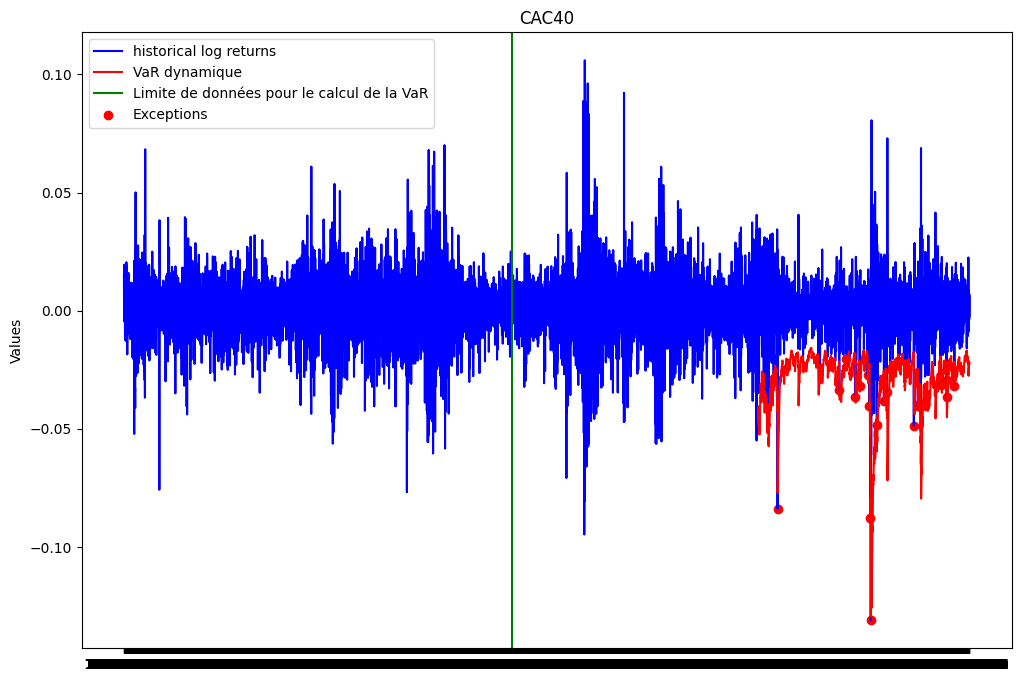

In [214]:
plt.figure(figsize=(12, 8))
plt.plot(ts_close.index, ts_close['log_return'], label="historical log returns", color = 'blue')
plt.plot(ts_close.index[train_size:], var_dyn_TVE_residus[train_size:], label='VaR dynamique', color = 'red')
plt.axvline(x = ts_close.index[train_size-251*10-1], color='green', linestyle='-', label='Limite de données pour le calcul de la VaR')
plt.scatter(ts_close.index[list_exceptions_TVE_residus], ts_close['log_return'][list_exceptions_TVE_residus], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()


# Conclusion
Ce projet a eu pour objectif d'estimer la VaR à horizon 1 jour et la VaR dynamique de différentes façons. Nous avons utilisé les données historiques du CaC40. Nous avons utilisé des méthodes non-paramétriques telles que la VaR historique et la VaR historique bootstrap. Nous avons également utilisé des méthodes paramétriques telles que la VaR gaussienne, la VaR skew-student et nous avons utilisé la théorie des valeurs extrêmes pour modéliser la VaR.  Nous avons également estimé de deux façons différentes la VaR dynamique. La première méthode consiste à calculer la VaR historique sur une fenêtre glissante de 251 jours. La deuxième méthode consiste à modéliser la VaR par un modèle AR-GARCH. Nous avons également validé nos modèles par des tests de backtesting. 

Les différentes approches de modélisation estime la VaR à horizon 1 jour à environ -0.03 avec un niveau de confiance de 99%. Ceci signifie que la perte maximale que peut subir un portefeuille sur un horizon de 1 jour avec un niveau de confiance de 99% est de 3%. Nous avons également validé nos modèles par des tests de backtesting qui ne rejettent pas l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%. 

La VaR dynamique estimée sur une fenêtre glissante de 251 jours n'a pas été validée par le test de backtesting. En effet, la pvalue du test est inférieure au seuil de 5%. Nous rejetons donc l'hypothèse nulle selon laquelle la probabilité d'exception est de 1%. Cependant, la VaR dynamique estimée par le modèle AR(1)-GARCH(1,1) donne des meilleurs résultats. L'hypothèse nulle du test selon laquelle le pourcentage d'exceptions est inférieur à 1% n'a pas été rejetée.